<a href="https://colab.research.google.com/github/MatteoFasulo/Sexism-detection/blob/assignment2/assignment_2_graph_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2


**Keywords**: Sexism Detection, Multi-class Classification, LLMs, Prompting


## Group

* Luca Babboni - luca.babboni2@studio.unibo.it
* Matteo Fasulo - matteo.fasulo@studio.unibo.it
* Maksim Omelchenko - maksim.omelchenko@studio.unibo.it
* Luca Tedeschini - luca.tedeschini3@studio.unibo.it



## Description

This notebook addresses [EDOS Task A](https://github.com/rewire-online/edos) on sexism detection.


## Problem definition

Given an input text sentence, the task is to label the sentence as sexist or not sexist (binary classification).

### Examples:

**Text**: *``Schedule a date with her, then don't show up. Then text her "GOTCHA B___H".''*

**Label**: Sexist

**Text**: *``That’s completely ridiculous a woman flashing her boobs is not sexual assault in the slightest.''*

**Label**: Not sexist



## Approach

We will tackle the binary classification task with LLMs.

In particular, we will consider zero and few-shot prompting approaches under the setting of In-Context Learning (ICL) to assess the capability of some popular open-source LLMs on this task. Furthermore, we will use Okapi BM25 score to rank the demonstrations and select the topK best ones to be used as examples inside the prompt.

In this way, we will be able to evaluate the performance of the models both by selecting a random set of examples and by selecting the best ones according to the BM25 score. We believe that the latter approach will lead to better results, as it will provide the model with more relevant examples to learn from.

>**Note** We are aware that selecting the best subset of examples using BM25 score is a dataset-dependent approach, and it may not generalize well to other datasets. However, we believe that it is a valid approach to evaluate the performance of the models on this specific dataset by varying the set of demonstrations used to prompt the model highlighting the importance of the selection of the examples.

## Execution Instructions

We are going to download LLMs from [Huggingface](https://huggingface.co/).

Many of these open-source LLMs require you to accept their "Community License Agreement" to download them.

In summary:

- If not already, create an account of Huggingface (~2 mins)
- Check a LLM model card page (e.g., [Mistral v3](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3)) and accept its "Community License Agreement".
- Go to your account -> Settings -> Access Tokens -> Create new token -> "Repositories permissions" -> add the LLM model card you want to use.
- Save the token (we'll need it later)

### Libraries

Assuming that we are working in a Colab environment, we need to update the BitsAndBytes library to the latest version.

In [10]:
%%capture
%pip install -U bitsandbytes huggingface_hub bm25_pt statsmodels

Since the library requires a restart of the runtime, we need to run the following cell which kills the current runtime.

In [ ]:
import os
os.kill(os.getpid(), 9)

At this point, we can just import all the libraries and start working on the assignment.

In [3]:
import os
import requests
import re
import random
import gc
from pathlib import Path
from copy import deepcopy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.stats.contingency_tables import mcnemar

from tqdm import tqdm

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from bm25_pt import BM25

import torch

import huggingface_hub
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

### Huggingface Login

Once we have created an account and an access token, we need to login to Huggingface via code. Assuming that we are still inside a notebook environment, we can run the following cell to login.

In [4]:
huggingface_hub.notebook_login()

As for the assignment 1, we will use a object-oriented approach to manage the models and the datasets by defining the class `SexismDetection`.

In [5]:
class SexismDetector:
    def __init__(self):
        self.seed = 69
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.DATA_FOLDER = Path("data")
        self.CSV_FOLDER = Path('csv')

        # Create data folder if it doesn't exist
        if not self.DATA_FOLDER.exists():
            self.DATA_FOLDER.mkdir(parents=True)
            print(f"Created folder {self.DATA_FOLDER}.")

        # Create CSV folder if it doesn't exist
        if not self.CSV_FOLDER.exists():
            self.CSV_FOLDER.mkdir(parents=True)
            print(f"Created folder {self.CSV_FOLDER}.")

        self.clear_cache()

    def clear_cache(self) -> None:
        """
        Clears the GPU cache and performs garbage collection.
        This method uses PyTorch's `torch.cuda.empty_cache()` to release all unoccupied cached memory
        currently held by the caching allocator so that those can be used in other GPU applications.
        It also calls Python's garbage collector to free up memory that is no longer in use.
        Returns:
            None
        """
        torch.cuda.empty_cache()

        with torch.no_grad():
            torch.cuda.empty_cache()

        gc.collect()

    def download_corpus(self, url: str) -> pd.DataFrame:
        """
        Downloads a corpus from the given URL and saves it as a CSV file in the data folder.
        Args:
            url (str): The URL of the corpus to download.
        Returns:
            pd.DataFrame: A DataFrame containing the contents of the downloaded CSV file.
        Raises:
            requests.exceptions.RequestException: If there is an issue with the HTTP request.
        """
        filename = url.split("/")[-1]
        if not (self.DATA_FOLDER / filename).exists():
            print(f"Created folder {self.DATA_FOLDER}.")

        response = requests.get(url)
        response.raise_for_status()
        with open(self.DATA_FOLDER / filename, 'w', encoding='utf-8') as f:
            f.write(response.text)

        return pd.read_csv(self.DATA_FOLDER / filename, encoding='utf-8')

    def load_model(self, model_card: str, with_4_bit: bool = True) -> tuple:
        """
        Loads a pre-trained model and its tokenizer with optional 4-bit quantization.

        Args:
            model_card (str): The identifier of the pre-trained model to load.
            with_4_bit (bool, optional): If True, loads the model with 4-bit quantization.
                                         If False, loads the model with 8-bit quantization.
                                         Defaults to True.

        Returns:
            tuple: A tuple containing the loaded model and tokenizer.
        """
        # Clear cache
        self.clear_cache()

        # Setup the quantization config
        quantization_config = BitsAndBytesConfig(load_in_8bit=True)
        if with_4_bit:
            quantization_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_quant_type="fp4",
                bnb_4bit_compute_dtype=torch.bfloat16
            )
        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(model_card)
        # Load the model
        model = AutoModelForCausalLM.from_pretrained(model_card, quantization_config=quantization_config)
        # Set the model to evaluation (inference) mode
        model.eval()

        return model, tokenizer

    def prepare_prompts(self, texts: pd.Series, prompt_template: list, tokenizer: AutoTokenizer) -> list:
        """
        Prepares prompts by applying a chat template to a series of input texts.

        Args:
            texts (pd.Series): A pandas Series containing the input texts.
            prompt_template (list): A list representing the prompt template with placeholders.
            tokenizer (AutoTokenizer): An instance of the AutoTokenizer used to tokenize the prompts.

        Returns:
            list: A list of tokenized prompts ready for generation.
        """
        # Store the prompts
        prompts = []
        # Iterate over the input texts
        for text in texts:

            # Create a deepcopy of the prompt template
            prompt_with_text = deepcopy(prompt_template)

            # Replace the placeholder with the input text
            prompt_with_text[1]['content'] = prompt_with_text[1]['content'].replace('{text}', text)

            # Apply the chat template to the input text
            full_prompt = tokenizer.apply_chat_template(
                prompt_with_text,
                tokenize=True,
                add_generation_prompt=True,
                return_dict=True,
                return_tensors="pt")
            # Move the full prompt to the device
            full_prompt = full_prompt.to(self.device)
            # Append the full prompt to the list of prompts
            prompts.append(full_prompt)

        return prompts

    def generate_responses(self, model: AutoModelForCausalLM, tokenizer: AutoTokenizer, prompt_examples: list, max_new_tokens: int = 1000) -> list:
        """
        Generates responses for a list of prompt examples using a specified language model and tokenizer.

        Args:
            model (AutoModelForCausalLM): The language model to use for generating responses.
            tokenizer (AutoTokenizer): The tokenizer associated with the language model.
            prompt_examples (list): A list of prompt examples to generate responses for.
            max_new_tokens (int, optional): The maximum number of new tokens to generate for each prompt. Defaults to 1000.

        Returns:
            list: A list of generated responses corresponding to each prompt example.
        """
        answers = []
        for prompt in tqdm(prompt_examples):
            response = model.generate(**prompt, max_new_tokens=max_new_tokens, pad_token_id=tokenizer.eos_token_id)
            answers.append(response)
        return answers

    def process_response(self, response: torch.Tensor, tokenizer: AutoTokenizer) -> int:
        """
        Processes the response tensor and determines if it contains a positive indication.

        Args:
            response (torch.Tensor): The tensor containing the response from the model.
            tokenizer (AutoTokenizer): The tokenizer used to decode the response tensor.

        Returns:
            int: Returns 1 if the decoded response contains 'YES' after 'ANSWER', otherwise returns 0.
        """
        response_text = tokenizer.decode(response[0])
        if 'YES' in response_text.split('ANSWER')[-1]:
            return 1
        else:
            return 0

    def get_generated_response(self, response: torch.Tensor, tokenizer: AutoTokenizer) -> str:
        """
        Decodes a tensor response into a cleaned string.

        Args:
            response (torch.Tensor): The tensor containing the response to decode.
            tokenizer (AutoTokenizer): The tokenizer used to decode the response.

        Returns:
            str: The cleaned and decoded response string.
        """
        response_text = tokenizer.decode(response[0])
        response_text = response_text.split('[/INST]')[-1]
        cleaned_string = re.sub(r'</s>', '', response_text).strip()
        return cleaned_string

    def compute_metrics(self, responses: list, y_true: list, tokenizer: AutoTokenizer) -> dict:
        """
        Compute the accuracy and fail ratio of the model's predictions.

        Args:
            responses (list): A list of responses generated by the model.
            y_true (list): A list of true labels corresponding to the responses.

        Returns:
            dict: A dictionary containing the accuracy and fail ratio of the predictions.
                - 'accuracy' (float): The proportion of correct predictions.
                - 'fail_ratio' (float): The proportion of incorrect predictions.
        """
        y_pred = [self.process_response(response=response, tokenizer=tokenizer) for response in responses]
        accuracy = (np.array(y_pred) == np.array(y_true)).mean()
        fail_ratio = (np.array(y_pred) != np.array(y_true)).mean()
        return {'accuracy': accuracy, 'fail_ratio': fail_ratio}

    def build_few_shot_demonstrations(self, demonstrations: pd.DataFrame, num_per_class: int = 2, custom_example_ids: dict = None) -> list:
        """
        Build few-shot demonstrations for a classification task.

        This method extracts a specified number of positive and negative samples from the provided DataFrame
        and combines them into a list of few-shot demonstrations. The demonstrations are then shuffled.

        Args:
            demonstrations (pd.DataFrame): A DataFrame containing the text samples and their corresponding labels.
                                           The DataFrame must have at least two columns: 'text' and 'label_sexist'.
            num_per_class (int): The number of samples to extract for each class (positive and negative). If an integer
                                 is provided, the same number of samples will be extracted for both classes. If a list
                                 of two integers is provided, the first integer specifies the number of positive samples
                                 and the second integer specifies the number of negative samples. Default is 2.
            custom_example_ids (dict, optional): A dictionary of custom example IDs to include in the few-shot demonstrations. This will be used later to check specific examples manually or by passing top demonstration examples according to a ranking criterion. Defaults to None.

        Returns:
            list: A list of few-shot demonstrations, where each demonstration is a list containing the text and its label.
                  The label is 1 for positive samples (sexist) and 0 for negative samples (not sexist).
        """
        if isinstance(num_per_class, int):
            num_per_class = [num_per_class, num_per_class]

        if custom_example_ids is None:
            # Extract a random sample of positive and negative demonstrations
            yes_samples = demonstrations[demonstrations['label_sexist'] == 'sexist'].sample(num_per_class[0], random_state=self.seed)
            no_samples = demonstrations[demonstrations['label_sexist'] == 'not sexist'].sample(num_per_class[1], random_state=self.seed)
        else:
            # Extract custom examples
            sexist_ids = custom_example_ids['sexist'][:num_per_class[0]]
            not_sexist_ids = custom_example_ids['not_sexist'][:num_per_class[1]]
            # Filter the demonstrations based on the custom example IDs
            yes_samples = demonstrations[demonstrations.index.isin(sexist_ids)]
            no_samples = demonstrations[demonstrations.index.isin(not_sexist_ids)]

        # Combine the samples into a list of few-shot demonstrations
        few_shot_demonstrations = list(pd.concat([yes_samples['text'], no_samples['text']]))
        few_shot_demonstrations = [[demonstration, label] for demonstration, label in zip(few_shot_demonstrations,
                                                                                            [1] * num_per_class[0] + [0] * num_per_class[1])]
        # Shuffle the few-shot demonstrations
        random.shuffle(few_shot_demonstrations)

        return few_shot_demonstrations

    def prepare_prompts_few_shot(self, texts: pd.Series, demonstrations: list, prompt_template: list, tokenizer: AutoTokenizer) -> list:
        """
        Prepares few-shot learning prompts for a given set of texts using a specified prompt template and tokenizer.

        Args:
            texts (pd.Series): A pandas Series containing the texts to be used for generating prompts.
            demonstrations (list): A list of tuples where each tuple contains a tweet (str) and its corresponding label (int).
            prompt_template (list): A list representing the prompt template to be used for generating prompts.
            tokenizer (AutoTokenizer): An instance of the AutoTokenizer to be used for tokenizing the prompts.

        Returns:
            list: A list of tokenized prompts ready for few-shot learning.
        """
        # Store the prompts
        prompts = []
        # Iterate over the input texts
        for text in texts:
            # Create a deepcopy of the prompt template
            prompt_with_text = deepcopy(prompt_template)
            demonstration = ''
            for tweet, label in demonstrations:
                if label == 1:
                    demonstration += '\tTEXT: ' + tweet + '\n\tANSWER: YES\n' # positive
                else:
                    demonstration += '\tTEXT: ' + tweet + '\n\tANSWER: NO\n' # negative

            # Remove the first tab character
            demonstration = demonstration[1:]
            # Replace the placeholders with the input text and few-shot demonstrations
            prompt_with_text[1]['content'] = prompt_with_text[1]['content'].replace('{examples}', demonstration)
            prompt_with_text[1]['content'] = prompt_with_text[1]['content'].replace('{text}', text)
            # Apply the chat template to the input text
            full_prompt = tokenizer.apply_chat_template(
                prompt_with_text,
                tokenize=True,
                add_generation_prompt=True,
                return_dict=True,
                return_tensors="pt")
            # Move the full prompt to the device
            full_prompt = full_prompt.to(self.device)
            # Append the full prompt to the list of prompts
            prompts.append(full_prompt)

        return prompts

    def few_shot_experiment(
            self,
            name: str,
            model: AutoModelForCausalLM,
            tokenizer: AutoTokenizer,
            data: pd.DataFrame,
            demonstrations: list,
            prompt_template: list,
            original_labels: list,
            models_predictions: pd.DataFrame,
            model_metrics: pd.DataFrame,
            custom_example_ids: dict = None,
            shots: int = 2,
            store_model_predictions: bool = False
        ) -> None:
        """
        Conducts a few-shot learning experiment using a given model and tokenizer.

        Args:
            name (str): The name of the model being used.
            model (AutoModelForCausalLM): The language model to be used for generating responses.
            tokenizer (AutoTokenizer): The tokenizer associated with the language model.
            data (pd.DataFrame): A DataFrame containing the input texts.
            demonstrations (list): A list of demonstration examples for few-shot learning.
            prompt_template (list): A list of prompt templates to be used for generating prompts.
            original_labels (list): The original labels for the data.
            models_predictions (pd.DataFrame): DataFrame to store the model's predictions.
            model_metrics (pd.DataFrame): DataFrame to store the model's performance metrics.
            custom_example_ids (dict, optional): A dictionary of custom example IDs to include in the few-shot demonstrations. This will be used later to check specific examples manually or by passing top demonstration examples according to a ranking criterion. Defaults to None.
            shots (int, optional): The number of shots (examples per class) to use for few-shot learning. Defaults to 2.
            store_model_predictions (bool, optional): Whether to store the model's predictions. Defaults to False.

        Returns:
            None
        """
        # Build few-shot demonstrations
        few_shot_demonstrations = self.build_few_shot_demonstrations(demonstrations, num_per_class=shots, custom_example_ids=custom_example_ids)
        # Prepare few-shot prompts
        prompts_few_shot = self.prepare_prompts_few_shot(texts=data['text'], demonstrations=few_shot_demonstrations, prompt_template=prompt_template, tokenizer=tokenizer)

        # Print few-shot prompt example
        print('Example of few-shot prompt')
        print(tokenizer.decode(prompts_few_shot[0].input_ids[0]))
        print('-' * 100)

        # Inference
        print('Inference:')
        # Generate responses
        answers = self.generate_responses(model=model, tokenizer=tokenizer, prompt_examples=prompts_few_shot)

        # Store model predictions
        if store_model_predictions:
            batch_predictions = [self.process_response(response=item, tokenizer=tokenizer) for item in answers]
            generated_answers = [self.get_generated_response(response=item, tokenizer=tokenizer) for item in answers]
            models_predictions[f'{name}_labels'] = batch_predictions
            models_predictions[f'{name}_answers'] = generated_answers

        # Compute metrics
        metrics = self.compute_metrics(responses=answers, y_true=original_labels, tokenizer=tokenizer)
        print('\n')

        # Store model metrics
        model_metrics.loc[len(model_metrics)] = {'model': name, 'accuracy': metrics['accuracy'], 'fail_ratio': metrics['fail_ratio']}

        # Print model metrics
        print(f'Model: {name}\tMetrics: {metrics}')

    def top_k_demonstrations(self, tokenizer: AutoTokenizer, test_data: pd.DataFrame, demonstrations: pd.DataFrame, k: int = 4) -> tuple:
        """
        Computes the top k sexist and non-sexist demonstrations based on BM25 scores given the test set.

        Args:
            tokenizer (AutoTokenizer): The tokenizer to be used for tokenizing the text.
            test_data (pd.DataFrame): The test data containing the text to be indexed.
            demonstrations (pd.DataFrame): The demonstrations containing the text and labels ('sexist' or 'not sexist').
            k (int, optional): The number of top demonstrations to return. Defaults to 4.

        Returns:
            tuple: A tuple containing two elements:
                - top_k_sexist (torch.Tensor): The top k sexist demonstrations based on BM25 scores.
                - top_k_non_sexist (torch.Tensor): The top k non-sexist demonstrations based on BM25 scores.
        """
        # Instantiate the bm25 using the tokenizer
        bm25 = BM25(tokenizer=tokenizer, device=self.device)

        # Assign the padding token to the tokenizer
        tokenizer.pad_token  = tokenizer.eos_token

        # Index the corpus
        bm25.index(test_data['text'].values.tolist())

        # Get the sexist queries
        sexist_queries = demonstrations[demonstrations['label_sexist'] == 'sexist']['text'].values.tolist()

        # Compute the BM25 scores for the sexist queries
        sexist_scores = bm25.score_batch(sexist_queries)

        # Get the non-sexist queries
        non_sexist_queries = demonstrations[demonstrations['label_sexist'] == 'not sexist']['text'].values.tolist()

        # Compute the BM25 scores for the non-sexist queries
        non_sexist_scores = bm25.score_batch(non_sexist_queries)

        # Compute the mean BM25 scores for the sexist and non-sexist queries
        mean_sexist_scores = torch.mean(sexist_scores, dim=1)
        mean_non_sexist_scores = torch.mean(non_sexist_scores, dim=1)

        # Then extract the top k sexist and non-sexist
        top_k_sexist = torch.topk(mean_sexist_scores, k=k)
        top_k_non_sexist = torch.topk(mean_non_sexist_scores, k=k)

        return top_k_sexist, top_k_non_sexist

    def local_to_global_idx(self, topk_tensor: torch.Tensor, original_data: pd.DataFrame, label_type: str) -> list:
        """
        Converts local tensor indices to global indices based on the original DataFrame.
        Args:
            topk_tensor (torch.Tensor): A tensor containing the top-k indices.
            original_data (pd.DataFrame): The original DataFrame containing the data.
            label_type (str): The type of label to filter by ('sexist' or 'not sexist').
        Returns:
            list: A list of global indices corresponding to the original DataFrame.
        """
        # Make a copy of the tensor indices
        topk_tensor_indices = topk_tensor.indices.clone()
        # Detatch the copy to the host memory and convert to numpy
        topk_tensor_indices = topk_tensor_indices.cpu().numpy()
        # Iterate over the tensor indices
        for idx, demo_idx in enumerate(topk_tensor_indices):
            # Check the label type
            if label_type == 'sexist':
                # Extract the sexist slice, reset indexes to local format and locate the correct one
                example = original_data[original_data['label_sexist'] == 'sexist'].reset_index(drop=True).iloc[demo_idx]
            else:
                # Extract the non-sexist slice, reset indexes to local format and locate the correct one
                example = original_data[original_data['label_sexist'] == 'not sexist'].reset_index(drop=True).iloc[demo_idx]

            # Get the rewire_id of the example (text ID)
            rewire_id = example['rewire_id']
            # Get the original index of the example
            original_idx = original_data[original_data['rewire_id'] == rewire_id].index[0]
            # Store the original index in the tensor indices array
            topk_tensor_indices[idx] = original_idx

        # Convert the tensor indices to a list
        return topk_tensor_indices.tolist()

First we will define the class object for the dataset and then we will load the data

In [ ]:
detector = SexismDetector()

Here we will load the test data given the URL of the file and encode it into a pandas DataFrame.

The function will return the DataFrame as defined below.

```python
def download_corpus(self, url: str) -> pd.DataFrame:
    """
    Downloads a corpus from the given URL and saves it as a CSV file in the data folder.
    Args:
        url (str): The URL of the corpus to download.
    Returns:
        pd.DataFrame: A DataFrame containing the contents of the downloaded CSV file.
    Raises:
        requests.exceptions.RequestException: If there is an issue with the HTTP request.
    """
    filename = url.split("/")[-1]
    if not (self.DATA_FOLDER / filename).exists():
        print(f"Created folder {self.DATA_FOLDER}.")

    response = requests.get(url)
    response.raise_for_status()
    with open(self.DATA_FOLDER / filename, 'w', encoding='utf-8') as f:
        f.write(response.text)
    
    return pd.read_csv(self.DATA_FOLDER / filename, encoding='utf-8')
```

> **Note**: The function is part of the class, but we decided to explicitly define it here for clarity.

In [ ]:
path_test = 'https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%202/data/a2_test.csv'
df = detector.download_corpus(url=path_test)

In [ ]:
df.head()

,rewire_id,text,label_sexist
0,sexism2022_english-17133,The boys must be gaming because there goes the...,not sexist
1,sexism2022_english-14197,Look at those eyes. Either someone unexpectedl...,sexist
2,sexism2022_english-3018,Old man mogs everyone in this sub,not sexist
3,sexism2022_english-5301,"Excellent, I was just looking at another post ...",not sexist
4,sexism2022_english-17796,So you run back to daddy whenever you need hel...,sexist


# Model 1 - Mistral V3 7B
As first model we are gonna analyze the performance of Mistral V3 7B parameter model.

## Task 1 - Model setup

In this section we will first load the model from Huggingface and then quantize it to fit into a single GPU either with 4bit or 8bit precision.

We defined a function which given the model card and the quantization type, loads the model and the tokenizer so that we can use them for the inference.

The following function is used to load the model and the tokenizer.

```python
def load_model(self, model_card: str, with_4_bit: bool = True) -> tuple:
    """
    Loads a pre-trained model and its tokenizer with optional 4-bit quantization.

    Args:
        model_card (str): The identifier of the pre-trained model to load.
        with_4_bit (bool, optional): If True, loads the model with 4-bit quantization.
                                        If False, loads the model with 8-bit quantization.
                                        Defaults to True.

    Returns:
        tuple: A tuple containing the loaded model and tokenizer.
    """
    # Clear cache
    self.clear_cache()

    # Setup the quantization config
    quantization_config = BitsAndBytesConfig(load_in_8bit=True)
    if with_4_bit:
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="fp4",
            bnb_4bit_compute_dtype=torch.bfloat16
        )
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_card)
    # Load the model
    model = AutoModelForCausalLM.from_pretrained(model_card, quantization_config=quantization_config)
    # Set the model to evaluation (inference) mode
    model.eval()

    return model, tokenizer
```

>**Note**: The default quantization is set to 4-bit to allow the model to fit into a single GPU (RTX 3080) with 10GB of memory. However, the final run of our notebook is done with 8-bit quantization to ensure that the model can fit into a single GPU on Colab T4.

Now we can define the model card and load the model and the tokenizer

In [ ]:
model_card = 'mistralai/Mistral-7B-Instruct-v0.3'
model, tokenizer = detector.load_model(model_card, with_4_bit=False)

device = model.device
print(f'Model loaded on {device}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Model loaded on cuda:0


## Task 2 - Prompt setup

Prompting requires an input pre-processing phase where we convert each input example into a specific instruction prompt.


**Prompt Template**

Use the following prompt template to process input texts.

In [ ]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        {text}

        ANSWER:
        """
    }
]

The following function is our implementation of the `prepare_prompts` function. It takes a pandas Series of texts, a prompt template, and a tokenizer as input and returns a list of tokenized prompts ready for generation.

```python
def prepare_prompts(self, texts: pd.Series, prompt_template: list, tokenizer: AutoTokenizer) -> list:
    """
    Prepares prompts by applying a chat template to a series of input texts.

    Args:
        texts (pd.Series): A pandas Series containing the input texts.
        prompt_template (list): A list representing the prompt template with placeholders.
        tokenizer (AutoTokenizer): An instance of the AutoTokenizer used to tokenize the prompts.

    Returns:
        list: A list of tokenized prompts ready for generation.
    """
    # Store the prompts
    prompts = []
    # Iterate over the input texts
    for text in texts:

        # Create a deepcopy of the prompt template
        prompt_with_text = deepcopy(prompt_template)

        # Replace the placeholder with the input text
        prompt_with_text[1]['content'] = prompt_with_text[1]['content'].replace('{text}', text)

        # Apply the chat template to the input text
        full_prompt = tokenizer.apply_chat_template(
            prompt_with_text,
            tokenize=True,
            add_generation_prompt=True,
            return_dict=True,
            return_tensors="pt")
        # Move the full prompt to the device
        full_prompt = full_prompt.to(self.device)
        # Append the full prompt to the list of prompts
        prompts.append(full_prompt)

    return prompts
```

Now we can apply the function to the test dataset and print one of the prompts to check if it is correct

In [ ]:
prompts = detector.prepare_prompts(texts=df['text'], prompt_template=prompt, tokenizer=tokenizer)

print(f"Prompt example: \n{tokenizer.decode(prompts[0].input_ids[0], skip_special_tokens=True)}")

Prompt example: 
You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        


## Task 3 - Inference

We are now ready to define the inference loop where we prompt the model with each pre-processed sample.

First we will define the `generate_responses` function which given the model, the tokenizer, the prompt examples and the maximum number of tokens to generate, generates the responses for each prompt example.

In particular, we will use the following function to generate the responses

```python
def generate_responses(self, model: AutoModelForCausalLM, tokenizer: AutoTokenizer, prompt_examples: list, max_new_tokens: int = 1000) -> list:
    """
    Generates responses for a list of prompt examples using a specified language model and tokenizer.

    Args:
        model (AutoModelForCausalLM): The language model to use for generating responses.
        tokenizer (AutoTokenizer): The tokenizer associated with the language model.
        prompt_examples (list): A list of prompt examples to generate responses for.
        max_new_tokens (int, optional): The maximum number of new tokens to generate for each prompt. Defaults to 1000.

    Returns:
        list: A list of generated responses corresponding to each prompt example.
    """
    answers = []
    for prompt in tqdm(prompt_examples):
        response = model.generate(**prompt, max_new_tokens=1000, pad_token_id=tokenizer.eos_token_id)
        answers.append(response)
    return answers
```

We will also define a function to process the response (`process_response`) and determine if it contains a positive indication. The function takes the response tensor and the tokenizer as input and returns 1 if the decoded response contains 'YES' after 'ANSWER', otherwise returns 0.

```python
def process_response(self, response: torch.Tensor, tokenizer: AutoTokenizer) -> int:
    """
    Processes the response tensor and determines if it contains a positive indication.

    Args:
        response (torch.Tensor): The tensor containing the response from the model.
        tokenizer (AutoTokenizer): The tokenizer used to decode the response tensor.

    Returns:
        int: Returns 1 if the decoded response contains 'YES' after 'ANSWER', otherwise returns 0.
    """
    response_text = tokenizer.decode(response[0])
    if 'YES' in response_text.split('ANSWER')[-1]:
        return 1
    else:
        return 0
```

Now we can generate all the responses for the test dataset and process them to get the predictions

In [ ]:
answers = detector.generate_responses(model=model, tokenizer=tokenizer, prompt_examples=prompts)

100%|██████████| 300/300 [04:01<00:00,  1.24it/s]


The predictions will be computed in a list-comprehension fashion, same applies for the generation of the answers

In [ ]:
batch_predictions = [detector.process_response(response=item, tokenizer=tokenizer) for item in answers]
generated_answers = [detector.get_generated_response(response=item, tokenizer=tokenizer) for item in answers]

We will also recover the original labels of the test dataset to compute the accuracy of the model later

In [ ]:
original_labels = [1 if label == 'sexist' else 0 for label in df['label_sexist']]

By defining a pandas dataframe to store the model prediction, later we will be able to compare the predictions with the original labels across all models in a single dataframe.

In [ ]:
models_predictions = pd.DataFrame({
    'text': df['text'],
    'original_labels': original_labels,
    'Mistralv3_zero_shot_labels': batch_predictions,
    'Mistralv3_zero_shot_answers': generated_answers
})

We can also inspect the dataframe and see the predictions and the original labels for each of the model we are going to analyze.

In [ ]:
models_predictions.head()

,text,original_labels,Mistralv3_zero_shot_labels,Mistralv3_zero_shot_answers
0,The boys must be gaming because there goes the...,0,1,YES
1,Look at those eyes. Either someone unexpectedl...,1,1,YES
2,Old man mogs everyone in this sub,0,0,NO
3,"Excellent, I was just looking at another post ...",0,1,YES
4,So you run back to daddy whenever you need hel...,1,1,YES


## Task 4 - Metrics

In order to evaluate selected LLMs, we need to compute performance metrics.

In particular, we are interested in computing **accuracy** since the provided data is balanced with respect to classification classes.

Moreover, we want to compute the ratio of failed responses generated by models.

That is, how frequent the LLM fails to follow instructions and provides incorrect responses that do not address the classification task.

We denote this metric as **fail-ratio**.

In summary, we parse generated responses as follows:
- 1 if the model says YES
- 0 if the model says NO
- 0 if the model does not answer in either way

We will define the function `compute_metrics` which given the predictions and the original labels, computes the accuracy and the fail-ratio of the model.

```python
def compute_metrics(self, responses: list, y_true: list) -> dict:
    """
    Compute the accuracy and fail ratio of the model's predictions.

    Args:
        responses (list): A list of responses generated by the model.
        y_true (list): A list of true labels corresponding to the responses.

    Returns:
        dict: A dictionary containing the accuracy and fail ratio of the predictions.
            - 'accuracy' (float): The proportion of correct predictions.
            - 'fail_ratio' (float): The proportion of incorrect predictions.
    """
    y_pred = [self.process_response(response) for response in responses]
    accuracy = (np.array(y_pred) == np.array(y_true)).mean()
    fail_ratio = (np.array(y_pred) != np.array(y_true)).mean()
    return {'accuracy': accuracy, 'fail_ratio': fail_ratio}
```

Now we can compute the metrics for the Mistral v3 model given the previous predictions and the original labels

In [ ]:
mistal_base_metrics = detector.compute_metrics(responses=answers, y_true=original_labels, tokenizer=tokenizer)
print(f"Mistral v3 Zero-Shot Metrics: {mistal_base_metrics}")

Mistral v3 Zero-Shot Metrics: {'accuracy': 0.6133333333333333, 'fail_ratio': 0.38666666666666666}


As we can see, the zero-shot Mistal v3 model has an accuracy of 0.61 which is quite low, but this is expected since the model did not receive any example on how the task should be performed.

Then we will define another dataframe which will store the model metrics in terms of accuracy and fail ration so that we can compare all the models easily in a single dataframe.

In [ ]:
# Create the new dataset for storing the metrics
model_metrics = pd.DataFrame(columns=['model', 'accuracy', 'fail_ratio'])

Here we will add the metrics of the zero shot Mistral v3 model to the dataframe

In [ ]:
# Add the computed metrics to the metric dataset
model_metrics.loc[len(model_metrics)] = {'model': 'Mistralv3_0_shot', **mistal_base_metrics}

And we can inspect the dataframe to see the metrics of the model

In [ ]:
model_metrics

,model,accuracy,fail_ratio
0,Mistralv3_0_shot,0.613333,0.386667


## Task 5 - Few-shot Inference

So far, we have tested models in a zero-shot fashion: we provide the input text to classify and instruct the model to generate a response.

We are now interested in performing few-shot prompting to see the impact of providing demonstration examples.

To do so, we slightly change the prompt template as follows.

In [ ]:
prompt_few_shot = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        {examples}

        TEXT:
        {text}

        ANSWER:
        """
    }
]

The new prompt template reports some demonstration examples to instruct the model.

We provide an equal number of demonstrations per class as shown in the example below.

```python
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: **example 1**
        ANSWER: YES
        TEXT: **example 2**
        ANSWER: NO

        TEXT:
        {text}

        ANSWER:
        """
    }
]
```  

>**Note**: We did not experiment with different numbers of demonstrations per class, but we believe that it could be an interesting experiment to perform in the future.

### Task 5.1 - Data preparation

First we will load as a pandas DataFrame the demonstrations dataset

In [ ]:
path_demonstrations = 'https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%202/data/demonstrations.csv'
demonstrations = detector.download_corpus(url=path_demonstrations)

Created folder data.


In [ ]:
demonstrations.head()

,rewire_id,text,label_sexist
0,sexism2022_english-10348,I would never have my kid go to a daycare with...,not sexist
1,sexism2022_english-7950,Democrat women are so butt fucking ugly.,sexist
2,sexism2022_english-7742,If you really wanted to twist the knife you’d ...,not sexist
3,sexism2022_english-16170,Those women are pro-rape. They didn’t care abo...,sexist
4,sexism2022_english-9857,Married a bitch... Is it the standard scenario...,sexist


Then we can define the build_few_shot_demonstrations function which given the demonstrations DataFrame, and the number of demonstrations per class, returns the demonstrations for the few shot prompting by taking a sample of the demonstrations for each class.

```python
def build_few_shot_demonstrations(self, demonstrations: pd.DataFrame, num_per_class: int = 2, custom_example_ids: list = []) -> list:
    """
    Build few-shot demonstrations for a classification task.

    This method extracts a specified number of positive and negative samples from the provided DataFrame
    and combines them into a list of few-shot demonstrations. The demonstrations are then shuffled.

    Args:
        demonstrations (pd.DataFrame): A DataFrame containing the text samples and their corresponding labels.
                                        The DataFrame must have at least two columns: 'text' and 'label_sexist'.
        num_per_class (int): The number of samples to extract for each class (positive and negative). If an integer
                                is provided, the same number of samples will be extracted for both classes. If a list
                                of two integers is provided, the first integer specifies the number of positive samples
                                and the second integer specifies the number of negative samples. Default is 2.
        custom_example_ids (list, optional): A list of custom example IDs to include in the few-shot demonstrations. This will be used later to check specific examples manually or by passing top demonstration examples according to a ranking criterion. Defaults to an empty list.

    Returns:
        list: A list of few-shot demonstrations, where each demonstration is a list containing the text and its label.
                The label is 1 for positive samples (sexist) and 0 for negative samples (not sexist).
    """
    if isinstance(num_per_class, int):
        num_per_class = [num_per_class, num_per_class]

    if len(custom_example_ids) == 0:
        # Extract a random sample of positive and negative demonstrations
        yes_samples = demonstrations[demonstrations['label_sexist'] == 'sexist'].sample(num_per_class[0], random_state=self.seed)
        no_samples = demonstrations[demonstrations['label_sexist'] == 'not sexist'].sample(num_per_class[1], random_state=self.seed)
    else:
        # Extract custom examples
        yes_samples = demonstrations[demonstrations.index.isin(custom_example_ids)]
        no_samples = demonstrations[~demonstrations.index.isin(custom_example_ids)]

    # Combine the samples into a list of few-shot demonstrations
    few_shot_demonstrations = list(pd.concat([yes_samples['text'], no_samples['text']]))
    few_shot_demonstrations = [[demonstration, label] for demonstration, label in zip(few_shot_demonstrations,
                                                                                        [1] * num_per_class[0] + [0] * num_per_class[1])]
    # Shuffle the few-shot demonstrations
    random.shuffle(few_shot_demonstrations)

    return few_shot_demonstrations
```

>**Note**: The function has an optional parameter to include custom examples in the few-shot demonstrations. This will be used to pass the top demonstration examples according to a ranking criterion and compare the performance of the models.

### Task 5.2 - Few shot with randomly sampled examples

#### Learning by 2-shot randomly sampled examples

In this section we will provide 2 randomly sampled examples (1 per class) to the model and check the performance of the model.

In [ ]:
detector.few_shot_experiment(
    name='Mistralv3_2_shot',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    shots=1,
    store_model_predictions=True
)

Example of few-shot prompt
<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: Rule one from someone that has been on this earth a little longer than most of you. "ALL WOMEN ARE BORN LIARS". I have never met one woman, that at one point of another lied to me or I caught them lying to someone else.
	ANSWER: YES
	TEXT: There are recorded case of women raping underage boys and still getting child support out of them even though they aren't 18 still.
	ANSWER: NO


        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        [/INST]
----------------------------------------------------------------------------------------------------
Inference:


100%|██████████| 300/300 [10:26<00:00,  2.09s/it]



Model: Mistralv3_2_shot	Metrics: {'accuracy': 0.7, 'fail_ratio': 0.3}


#### Learning by 4-shot randomly sampled examples

In this section we will provide 4 randomly sampled examples (2 per class) to the model and check the performance of the model.

In [ ]:
detector.few_shot_experiment(
    name='Mistralv3_4_shot',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    shots=2,
    store_model_predictions=True
)

Example of few-shot prompt
<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: Rule one from someone that has been on this earth a little longer than most of you. "ALL WOMEN ARE BORN LIARS". I have never met one woman, that at one point of another lied to me or I caught them lying to someone else.
	ANSWER: YES
	TEXT: There are recorded case of women raping underage boys and still getting child support out of them even though they aren't 18 still.
	ANSWER: NO
	TEXT: We know Islam well through her deeds her acolytes are special needs and when they fuck a little kid (which their book does NOT forbid) you can't tell which they chose to rut: a boy, a girl, or wee goat's butt!
	ANSWER: NO
	TEXT: Cant seem to keep her legs closed even while walking skank
	ANSWER: YES


        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        [/I

100%|██████████| 300/300 [08:10<00:00,  1.63s/it]




Model: Mistralv3_4_shot	Metrics: {'accuracy': 0.77, 'fail_ratio': 0.23}


#### Learning by 8-shot randomly sampled examples

In this section we will provide 8 randomly sampled examples (4 per class) to the model and check the performance of the model.

In [ ]:
detector.few_shot_experiment(
    name='Mistralv3_8_shot',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    shots=4,
    store_model_predictions=True
)

Example of few-shot prompt
<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: I talk to a girl then their retard friends butt in and take her away, so
	ANSWER: NO
	TEXT: There are recorded case of women raping underage boys and still getting child support out of them even though they aren't 18 still.
	ANSWER: NO
	TEXT: We know Islam well through her deeds her acolytes are special needs and when they fuck a little kid (which their book does NOT forbid) you can't tell which they chose to rut: a boy, a girl, or wee goat's butt!
	ANSWER: NO
	TEXT: Rule one from someone that has been on this earth a little longer than most of you. "ALL WOMEN ARE BORN LIARS". I have never met one woman, that at one point of another lied to me or I caught them lying to someone else.
	ANSWER: YES
	TEXT: Cant seem to keep her legs closed even while walking skank
	ANSWER: YES
	TEXT: Tell t

100%|██████████| 300/300 [07:00<00:00,  1.40s/it]




Model: Mistralv3_8_shot	Metrics: {'accuracy': 0.7466666666666667, 'fail_ratio': 0.25333333333333335}


### Task 5.3 - Few shot with topK demonstration examples

In this part, we aim to improve the selection of demonstration examples by using the Okapi BM25 score to rank and select the topK best examples for inclusion in the prompt.

Given that our test set remains unchanged, we will identify the most "similar" examples to use as demonstrations for the model. Similarity can be defined in various ways, but in this case, we will use the Okapi BM25 score for ranking.

The Okapi BM25 score is a ranking function used by search engines to rank documents based on their relevance to a given search query. Typically, it is employed in Information Retrieval (IR) systems to rank documents according to their relevance to a query.

In our scenario, instead of a query, we have a set of examples. We will use the BM25 score to rank the relevance of each demonstration example concerning the entire test set. The score is calculated by evaluating the similarity between each demonstration and each element in the test set. These similarity scores are then averaged to obtain the final score for each demonstration. In this way, the final score will be the relevance of a given demonstration with respect to the entire test set.

The intuition behind this approach is that the model will benefit more from examples that are more relevant to the test set highlighting the importance of the selection of the examples under the setting of In-Context Learning.

>**Note** Since we are not allowed to change the prompt content, the only degree of freedom inside our setting is the selection of the demonstration examples. BM25 score is indeed a dataset-dependent approach and may not generalize well to other datasets. We believe that this is still a good showcase of the importance of selecting the best examples to prompt the model.

The `top_k_demonstrations` function performs the aforementioned steps to select the topK best examples according to the BM25 score.

In this case, k is set to 4 (thus extracting 4 positive and 4 negative examples) to provide the model with a balanced set of demonstrations. Each time we will just take a slice of the topK demonstrations to provide to the model so that in the 2-shot case we will take the first 1 demonstration per class, in the 4-shot case we will take the first 2 and so on.

In [ ]:
top_k_sexist, top_k_non_sexist = detector.top_k_demonstrations(tokenizer=tokenizer, test_data=df, demonstrations=demonstrations, k=4)

  0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/bm25_pt/bm25.py:28: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return torch.sparse_csr_tensor(idx_ptr, idxs, vals, size=csr.shape)


We can then define a dictionary which will store the topK demonstration examples IDs allowing us to retrieve them inside the dataset. In this way we can pass only these top demonstration examples to the model to be included in the prompt.

In [ ]:
topK_examples = {
    "sexist" : detector.local_to_global_idx(top_k_sexist, demonstrations, label_type='sexist'),
    "not_sexist" : detector.local_to_global_idx(top_k_non_sexist, demonstrations, label_type='not sexist')
}

In [ ]:
for key, values in topK_examples.items():
  print(f"Examples for {key}")
  for value in values:
    print("[", demonstrations.iloc[value]['label_sexist'], "] ", demonstrations.iloc[value]['text'])
  print()

Examples for sexist
[ sexist ]  oi [USER] [USER] you're fucked. OBESE fat cunt knows monkey, has her phone number, and won't turn her in. that's embarrassing for tellmama and faith matters. tut tut. need to make sure they're aware of who they're nominating for awards in future.
[ sexist ]  shower. Fucking plebe. Pretty much that whole sub. "Shower. You know you can't pause WOW in the middle of raid, right n00b? God females suck at logic, I'm Going My Own Way! God, I can't wait to tell everyone all the time for the next 50 years."
[ sexist ]  I would just start fucking her!! What's your problem, bro? You don't ask, you just do it!! In my 42 years on this earth I've never had a female that wasn't a relative sleep over at my crib/pad and not give me some pussy!! You are simping big time!!
[ sexist ]  Thank you, Fedra, but I'm not the only one who might suffer this bitch Flossie 🌩🌦☂ Pray she makes a hard right out into the ocean...in the meantime, get your waders out, kids. [USER] [USER] [

#### Learning by 2-shot with topK demonstration examples

In this section we will provide the topK demonstration examples to the model and check the performance of the model with 2-shot.

In [ ]:
detector.few_shot_experiment(
    name='Mistralv3_2_shot_custom',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    custom_example_ids=topK_examples,
    shots=1,
    store_model_predictions=True
)

Example of few-shot prompt
<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: [USER] you are correct. If they are fleeing war, hunger, deprivation and leaving the women and children behind is that the kind of male we want in our countries? I wouldn't breed a mongrel with a purebred because I wouldn't want to degrade the stock.
	ANSWER: NO
	TEXT: oi [USER] [USER] you're fucked. OBESE fat cunt knows monkey, has her phone number, and won't turn her in. that's embarrassing for tellmama and faith matters. tut tut. need to make sure they're aware of who they're nominating for awards in future.
	ANSWER: YES


        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        [/INST]
----------------------------------------------------------------------------------------------------
Inference:


100%|██████████| 300/300 [05:59<00:00,  1.20s/it]



Model: Mistralv3_2_shot_custom	Metrics: {'accuracy': 0.73, 'fail_ratio': 0.27}


#### Learning by 4-shot with topK demonstration examples

In this section we will provide the topK demonstration examples to the model and check the performance of the model with 4-shot.

In [ ]:
detector.few_shot_experiment(
    name='Mistralv3_4_shot_custom',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    custom_example_ids=topK_examples,
    shots=2,
    store_model_predictions=True
)

Example of few-shot prompt
<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: [USER] you are correct. If they are fleeing war, hunger, deprivation and leaving the women and children behind is that the kind of male we want in our countries? I wouldn't breed a mongrel with a purebred because I wouldn't want to degrade the stock.
	ANSWER: NO
	TEXT: Why not do it in person at work? Even if she's shy, it'd be the most natural thing to do since that's how she knows you. If she's shy like does not ever want to talk shy, then texting would be a good choice
	ANSWER: NO
	TEXT: shower. Fucking plebe. Pretty much that whole sub. "Shower. You know you can't pause WOW in the middle of raid, right n00b? God females suck at logic, I'm Going My Own Way! God, I can't wait to tell everyone all the time for the next 50 years."
	ANSWER: YES
	TEXT: oi [USER] [USER] you're fucked. OBES

100%|██████████| 300/300 [06:37<00:00,  1.32s/it]




Model: Mistralv3_4_shot_custom	Metrics: {'accuracy': 0.7466666666666667, 'fail_ratio': 0.25333333333333335}


#### Learning by 8-shot with topK demonstration examples

In this section we will provide the topK demonstration examples to the model and check the performance of the model with 8-shot.

In [ ]:
detector.few_shot_experiment(
    name='Mistralv3_8_shot_custom',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    custom_example_ids=topK_examples,
    shots=4,
    store_model_predictions=True
)

Example of few-shot prompt
<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: I would just start fucking her!! What's your problem, bro? You don't ask, you just do it!! In my 42 years on this earth I've never had a female that wasn't a relative sleep over at my crib/pad and not give me some pussy!! You are simping big time!!
	ANSWER: YES
	TEXT: Thank you, Fedra, but I'm not the only one who might suffer this bitch Flossie 🌩🌦☂ Pray she makes a hard right out into the ocean...in the meantime, get your waders out, kids. [USER] [USER] [USER] [USER] [USER] [USER]
	ANSWER: YES
	TEXT: That's why I want to apologize, because I don't want her to think I'm weird. I want to date her, which I can't do if she thinks I'm a weirdo
	ANSWER: NO
	TEXT: oi [USER] [USER] you're fucked. OBESE fat cunt knows monkey, has her phone number, and won't turn her in. that's embarrassing for 

100%|██████████| 300/300 [08:22<00:00,  1.68s/it]




Model: Mistralv3_8_shot_custom	Metrics: {'accuracy': 0.72, 'fail_ratio': 0.28}


In [ ]:
model_metrics

,model,accuracy,fail_ratio
0,Mistralv3_0_shot,0.613333,0.386667
1,Mistralv3_2_shot,0.700000,0.300000
2,Mistralv3_4_shot,0.770000,0.230000
3,Mistralv3_8_shot,0.746667,0.253333
4,Mistralv3_2_shot_custom,0.730000,0.270000
5,Mistralv3_4_shot_custom,0.746667,0.253333
6,Mistralv3_8_shot_custom,0.720000,0.280000


# Model 2 - Llama 3.1 8B

## Task 1 - Model setup

First of all, since the GPU memory is limited, we will delete the variable associated with the model. In this way, the variable will be moved to the heap memory thus allowing us to call the garbage collector to free the heap memory.

In [ ]:
del model

To be completely sure, we will also clear the cache of the GPU and then call the garbage collector.

In [ ]:
torch.cuda.empty_cache()

with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()

0

Starting from this point, we will experiment with LLama 3.1 8B model. The model is loaded in the same way of the Mistral v3 using 8-bit quantization.

In [ ]:
#load Llama3.1 8B model
model_card = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
model, tokenizer = detector.load_model(model_card, with_4_bit=False)

device = model.device
print(f'Model loaded on {device}')

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

Model loaded on cuda:0


## Task 2 - Prompt setup

Prompt setup follows precisely the same steps as for the Mistral v3 model.

In [ ]:
prompts = detector.prepare_prompts(texts=df['text'], prompt_template=prompt, tokenizer=tokenizer)

print(f"Prompt example: \n{tokenizer.decode(prompts[0].input_ids[0], skip_special_tokens=True)}")

Prompt example: 
system

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.user

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:assistant




## Task 3 - Inference

First we will generate the responses for the test dataset and process them to get the predictions. In this way we end up in having the zero-shot predictions for the Llama 3.1 8B model.

In [ ]:
answers = detector.generate_responses(model=model, tokenizer=tokenizer, prompt_examples=prompts)

100%|██████████| 300/300 [01:46<00:00,  2.83it/s]


In [ ]:
batch_predictions = [detector.process_response(response=item, tokenizer=tokenizer) for item in answers]
generated_answers = [detector.get_generated_response(response=item, tokenizer=tokenizer) for item in answers]

In [ ]:
models_predictions['Llama3_zero_shot_labels'] = batch_predictions
models_predictions['Llama3_zero_shot_answers'] = generated_answers

## Task 4 - Metrics

We can compute the metrics associated with the zero-shot Llama 3.1 8B model and add them to the dataframe.

In [ ]:
llama_base_metrics = detector.compute_metrics(responses=answers, y_true=original_labels, tokenizer=tokenizer)
print(f"Llama3 Zero-Shot Metrics: {llama_base_metrics}")

Llama3 Zero-Shot Metrics: {'accuracy': 0.6333333333333333, 'fail_ratio': 0.36666666666666664}


In [ ]:
# Add the computed metrics to the metric dataset
model_metrics.loc[len(model_metrics)] = {'model': 'Llama3_0_shot', **llama_base_metrics}

## Task 5 - Few-shot Inference

### Task 5.1 - Few shot with randomly sampled examples

#### Learning by 2-shot randomly sampled examples

In this section we will provide 2 randomly sampled examples (1 per class) to the model and check the performance of the model.

In [ ]:
detector.few_shot_experiment(
    name='Llama3_2_shot',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    shots=1,
    store_model_predictions=True
)

Example of few-shot prompt
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.<|eot_id|><|start_header_id|>user<|end_header_id|>

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: Rule one from someone that has been on this earth a little longer than most of you. "ALL WOMEN ARE BORN LIARS". I have never met one woman, that at one point of another lied to me or I caught them lying to someone else.
	ANSWER: YES
	TEXT: There are recorded case of women raping underage boys and still getting child support out of them even though they aren't 18 still.
	ANSWER: NO


        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:<|eot_id|><|start_header_id|>assistant<|end_header_id|>


--------------------------------------------------------------------------------------------------

100%|██████████| 300/300 [01:48<00:00,  2.77it/s]



Model: Llama3_2_shot	Metrics: {'accuracy': 0.66, 'fail_ratio': 0.34}


#### Learning by 4-shot randomly sampled examples

In this section we will provide 4 randomly sampled examples (2 per class) to the model and check the performance of the model.

In [ ]:
detector.few_shot_experiment(
    name='Llama3_4_shot',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    shots=2,
    store_model_predictions=True
)

Example of few-shot prompt
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.<|eot_id|><|start_header_id|>user<|end_header_id|>

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: There are recorded case of women raping underage boys and still getting child support out of them even though they aren't 18 still.
	ANSWER: NO
	TEXT: Cant seem to keep her legs closed even while walking skank
	ANSWER: YES
	TEXT: We know Islam well through her deeds her acolytes are special needs and when they fuck a little kid (which their book does NOT forbid) you can't tell which they chose to rut: a boy, a girl, or wee goat's butt!
	ANSWER: NO
	TEXT: Rule one from someone that has been on this earth a little longer than most of you. "ALL WOMEN ARE BORN LIARS". I have never met one woman, that at one point of another lied 

100%|██████████| 300/300 [02:06<00:00,  2.38it/s]




Model: Llama3_4_shot	Metrics: {'accuracy': 0.7333333333333333, 'fail_ratio': 0.26666666666666666}


#### Learning by 8-shot randomly sampled examples

In this section we will provide 8 randomly sampled examples (4 per class) to the model and check the performance of the model.

In [ ]:
detector.few_shot_experiment(
    name='Llama3_8_shot',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    shots=4,
    store_model_predictions=True
)

Example of few-shot prompt
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.<|eot_id|><|start_header_id|>user<|end_header_id|>

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: We know Islam well through her deeds her acolytes are special needs and when they fuck a little kid (which their book does NOT forbid) you can't tell which they chose to rut: a boy, a girl, or wee goat's butt!
	ANSWER: NO
	TEXT: That's pretty much my position. I don't like her as a person (don't hate her either, just don't particularly like her), but the controversy surrounding her is a perfect example of media & SJW double-standards.
	ANSWER: NO
	TEXT: Tell that worthless cunt she gets the lead first.
	ANSWER: YES
	TEXT: I did this years ago and used a photo of my brothers family. It fit the bill. Unfortunately some of the w

100%|██████████| 300/300 [02:29<00:00,  2.00it/s]




Model: Llama3_8_shot	Metrics: {'accuracy': 0.7033333333333334, 'fail_ratio': 0.2966666666666667}


### Task 5.2 - Few shot with topK demonstration examples

We can then define a dictionary which will store the topK demonstration examples IDs allowing us to retrieve them inside the dataset. In this way we can pass only these top demonstration examples to the model to be included in the prompt.

#### Learning by 2-shot with topK demonstration examples

In this section we will provide the topK demonstration examples to the model and check the performance of the model with 2-shot.

In [ ]:
detector.few_shot_experiment(
    name='Llama3_2_shot_custom',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    custom_example_ids=topK_examples,
    shots=1,
    store_model_predictions=True
)

Example of few-shot prompt
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.<|eot_id|><|start_header_id|>user<|end_header_id|>

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: oi [USER] [USER] you're fucked. OBESE fat cunt knows monkey, has her phone number, and won't turn her in. that's embarrassing for tellmama and faith matters. tut tut. need to make sure they're aware of who they're nominating for awards in future.
	ANSWER: YES
	TEXT: [USER] you are correct. If they are fleeing war, hunger, deprivation and leaving the women and children behind is that the kind of male we want in our countries? I wouldn't breed a mongrel with a purebred because I wouldn't want to degrade the stock.
	ANSWER: NO


        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:<|eot_id|>



  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 1/300 [00:01<05:03,  1.02s/it]

  1%|          | 2/300 [00:01<04:55,  1.01it/s]

  1%|          | 3/300 [00:02<04:32,  1.09it/s]

  1%|▏         | 4/300 [00:03<03:42,  1.33it/s]

  2%|▏         | 5/300 [00:03<03:14,  1.52it/s]

  2%|▏         | 6/300 [00:04<02:57,  1.66it/s]

  2%|▏         | 7/300 [00:04<02:59,  1.63it/s]

  3%|▎         | 8/300 [00:05<03:00,  1.61it/s]

  3%|▎         | 9/300 [00:06<02:59,  1.62it/s]

  3%|▎         | 10/300 [00:06<02:49,  1.71it/s]

  4%|▎         | 11/300 [00:07<02:31,  1.90it/s]

  4%|▍         | 12/300 [00:07<02:20,  2.05it/s]

  4%|▍         | 13/300 [00:07<02:12,  2.17it/s]

  5%|▍         | 14/300 [00:08<02:07,  2.24it/s]

  5%|▌         | 15/300 [00:08<02:01,  2.34it/s]

  5%|▌         | 16/300 [00:09<02:00,  2.36it/s]

  6%|▌         | 17/300 [00:09<01:54,  2.48it/s]

  6%|▌         | 18/300 [00:09<01:52,  2.52it/s]

  6%|▋         | 19/300 [00:10<01:49,  2.56it/s]

  7%|▋         |



Model: Llama3_2_shot_custom	Metrics: {'accuracy': 0.6433333333333333, 'fail_ratio': 0.3566666666666667}


#### Learning by 4-shot with topK demonstration examples

In this section we will provide the topK demonstration examples to the model and check the performance of the model with 4-shot.

In [ ]:
detector.few_shot_experiment(
    name='Llama3_4_shot_custom',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    custom_example_ids=topK_examples,
    shots=2,
    store_model_predictions=True
)

Example of few-shot prompt
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.<|eot_id|><|start_header_id|>user<|end_header_id|>

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: Why not do it in person at work? Even if she's shy, it'd be the most natural thing to do since that's how she knows you. If she's shy like does not ever want to talk shy, then texting would be a good choice
	ANSWER: NO
	TEXT: shower. Fucking plebe. Pretty much that whole sub. "Shower. You know you can't pause WOW in the middle of raid, right n00b? God females suck at logic, I'm Going My Own Way! God, I can't wait to tell everyone all the time for the next 50 years."
	ANSWER: YES
	TEXT: [USER] you are correct. If they are fleeing war, hunger, deprivation and leaving the women and children behind is that the kind of male we wan

100%|██████████| 300/300 [02:19<00:00,  2.15it/s]




Model: Llama3_4_shot_custom	Metrics: {'accuracy': 0.6533333333333333, 'fail_ratio': 0.3466666666666667}


#### Learning by 8-shot with topK demonstration examples

In this section we will provide the topK demonstration examples to the model and check the performance of the model with 8-shot.

In [ ]:
detector.few_shot_experiment(
    name='Llama3_8_shot_custom',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    custom_example_ids=topK_examples,
    shots=4,
    store_model_predictions=True
)

Example of few-shot prompt
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.<|eot_id|><|start_header_id|>user<|end_header_id|>

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: So defensive. Your waiting for someone to convince you paying for it is a good idea and no one has. Keep it, fuck her, don’t pay for it. I still don’t think it’s worth the trouble but you do you.
	ANSWER: NO
	TEXT: Why not do it in person at work? Even if she's shy, it'd be the most natural thing to do since that's how she knows you. If she's shy like does not ever want to talk shy, then texting would be a good choice
	ANSWER: NO
	TEXT: shower. Fucking plebe. Pretty much that whole sub. "Shower. You know you can't pause WOW in the middle of raid, right n00b? God females suck at logic, I'm Going My Own Way! God, I can't wait t

100%|██████████| 300/300 [02:54<00:00,  1.72it/s]




Model: Llama3_8_shot_custom	Metrics: {'accuracy': 0.72, 'fail_ratio': 0.28}


---

### Exporting the results

Finally, we will export the results of the models in a CSV file so that we can analyze them later and plot all the confusion matrices of every model.

In [ ]:
models_predictions.to_csv(f'{detector.CSV_FOLDER}{os.sep}models_predictions.csv', index=False)

The same is performed for the metrics of the models.

In [ ]:
model_metrics.to_csv(f'{detector.CSV_FOLDER}{os.sep}model_metrics.csv', index=False)

In [ ]:
models_predictions

,text,original_labels,Mistralv3_zero_shot_labels,Mistralv3_zero_shot_answers,Mistralv3_2_shot_labels,Mistralv3_2_shot_answers,Mistralv3_4_shot_labels,Mistralv3_4_shot_answers,Mistralv3_8_shot_labels,Mistralv3_8_shot_answers,...,Llama3_4_shot_labels,Llama3_4_shot_answers,Llama3_8_shot_labels,Llama3_8_shot_answers,Llama3_2_shot_custom_labels,Llama3_2_shot_custom_answers,Llama3_4_shot_custom_labels,Llama3_4_shot_custom_answers,Llama3_8_shot_custom_labels,Llama3_8_shot_custom_answers
0,The boys must be gaming because there goes the...,0,1.0,YES,1.0,YES,0.0,NO,1.0,YES,...,0,<|begin_of_text|><|start_header_id|>system<|en...,0,<|begin_of_text|><|start_header_id|>system<|en...,0,<|begin_of_text|><|start_header_id|>system<|en...,0,<|begin_of_text|><|start_header_id|>system<|en...,0,<|begin_of_text|><|start_header_id|>system<|en...
1,Look at those eyes. Either someone unexpectedl...,1,1.0,YES,1.0,YES,1.0,YES,1.0,YES,...,1,<|begin_of_text|><|start_header_id|>system<|en...,1,<|begin_of_text|><|start_header_id|>system<|en...,1,<|begin_of_text|><|start_header_id|>system<|en...,1,<|begin_of_text|><|start_header_id|>system<|en...,1,<|begin_of_text|><|start_header_id|>system<|en...
2,Old man mogs everyone in this sub,0,0.0,NO,0.0,NO (The text does not contain sexism as it doe...,0.0,NO,0.0,NO,...,0,<|begin_of_text|><|start_header_id|>system<|en...,0,<|begin_of_text|><|start_header_id|>system<|en...,1,<|begin_of_text|><|start_header_id|>system<|en...,0,<|begin_of_text|><|start_header_id|>system<|en...,0,<|begin_of_text|><|start_header_id|>system<|en...
3,"Excellent, I was just looking at another post ...",0,1.0,YES,1.0,YES,1.0,YES,1.0,YES,...,1,<|begin_of_text|><|start_header_id|>system<|en...,1,<|begin_of_text|><|start_header_id|>system<|en...,1,<|begin_of_text|><|start_header_id|>system<|en...,1,<|begin_of_text|><|start_header_id|>system<|en...,1,<|begin_of_text|><|start_header_id|>system<|en...
4,So you run back to daddy whenever you need hel...,1,1.0,YES,1.0,YES,1.0,YES,1.0,YES,...,1,<|begin_of_text|><|start_header_id|>system<|en...,1,<|begin_of_text|><|start_header_id|>system<|en...,1,<|begin_of_text|><|start_header_id|>system<|en...,1,<|begin_of_text|><|start_header_id|>system<|en...,1,<|begin_of_text|><|start_header_id|>system<|en...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,It stops white women from being hit (or worse)...,0,1.0,YES,1.0,YES (This statement contains both sexism and r...,1.0,YES,1.0,YES,...,1,<|begin_of_text|><|start_header_id|>system<|en...,1,<|begin_of_text|><|start_header_id|>system<|en...,1,<|begin_of_text|><|start_header_id|>system<|en...,1,<|begin_of_text|><|start_header_id|>system<|en...,1,<|begin_of_text|><|start_header_id|>system<|en...
296,Alexa Chung Her father is 3/4 Chinese if that ...,0,1.0,YES,0.0,NO,0.0,NO,0.0,NO,...,1,<|begin_of_text|><|start_header_id|>system<|en...,0,<|begin_of_text|><|start_header_id|>system<|en...,1,<|begin_of_text|><|start_header_id|>system<|en...,1,<|begin_of_text|><|start_header_id|>system<|en...,0,<|begin_of_text|><|start_header_id|>system<|en...
297,Chelsea Clinton leaned over to her husband and...,0,1.0,YES,1.0,YES (The statement implies a negative and disr...,0.0,NO (The text does not explicitly contain sexis...,1.0,YES,...,0,<|begin_of_text|><|start_header_id|>system<|en...,0,<|begin_of_text|><|start_header_id|>system<|en...,1,<|begin_of_text|><|start_header_id|>system<|en...,1,<|begin_of_text|><|start_header_id|>system<|en...,0,<|begin_of_text|><|start_header_id|>system<|en...
298,"Thats because all women are different, but all...",0,1.0,YES,1.0,YES,1.0,YES (This statement generalizes all women base...,1.0,YES,...,1,<|begin_of_text|><|start_header_id|>system<|en...,1,<|begin_of_text|><|start_header_id|>system<|en...,1,<|begin_of_text|><|start_header_id|>system<|en...,1,<|begin_of_text|><|start_header_id|>system<|en...,1,<|begin_of_text|><|start_header_id|>system<|en...


In [ ]:
model_metrics

,model,accuracy,fail_ratio
0,Mistralv3_0_shot,0.613333,0.386667
1,Mistralv3_2_shot,0.700000,0.300000
2,Mistralv3_4_shot,0.770000,0.230000
3,Mistralv3_8_shot,0.746667,0.253333
4,Mistralv3_2_shot_custom,0.730000,0.270000
5,Mistralv3_4_shot_custom,0.746667,0.253333
6,Mistralv3_8_shot_custom,0.720000,0.280000
7,Llama3_0_shot,0.633333,0.366667
8,Llama3_0_shot,0.633333,0.366667
9,Llama3_2_shot,0.660000,0.340000


# Task 6 -  Error Analysis and results comparison

We are now interested in evaluating model responses and comparing their performance.

This analysis helps us in understanding

- Classification task performance gap: are the models good at this task?
- Generation quality: which kind of responses do models generate?
- Errors: which kind of mistakes do models do?

In [ ]:
import os
import requests
import re
import random
import gc
from pathlib import Path
from copy import deepcopy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.stats.contingency_tables import mcnemar

from tqdm import tqdm

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from bm25_pt import BM25

import torch

import huggingface_hub
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

In [2]:
detector = SexismDetector()

NameError: name 'SexismDetector' is not defined

**Instructions**

In order to get Task 6 points, we require you to:

* Compare classification performance of selected LLMs in a Table.
* Compute confusion matrices for selected LLMs.
* Briefly summarize your observations on generated responses.

In [4]:
def compute_p_value(pipeline1_preds : pd.Series, pipeline2_preds : pd.Series, true_labels: pd.Series):
    """
    Compute the p-value for statistical significance of improvement between two binary classification pipelines.

    Parameters:
        pipeline1_preds (pd.Series): Predictions from pipeline 1 (binary values: 0 or 1).
        pipeline2_preds (pd.Series): Predictions from pipeline 2 (binary values: 0 or 1).
        true_labels (pd.Series): Ground truth labels (binary values: 0 or 1).

    Returns:
        float: The p-value for the McNemar's test.
    """
    # Convert inputs to numpy arrays
    pipeline1_preds = np.array(pipeline1_preds)
    pipeline2_preds = np.array(pipeline2_preds)
    true_labels = np.array(true_labels)

    # Create the contingency table
    both_correct = np.sum((pipeline1_preds == true_labels) & (pipeline2_preds == true_labels))
    only_pipeline1_correct = np.sum((pipeline1_preds == true_labels) & (pipeline2_preds != true_labels))
    only_pipeline2_correct = np.sum((pipeline1_preds != true_labels) & (pipeline2_preds == true_labels))
    both_incorrect = np.sum((pipeline1_preds != true_labels) & (pipeline2_preds != true_labels))

    contingency_table = np.array([[both_correct, only_pipeline2_correct],
                                   [only_pipeline1_correct, both_incorrect]])

    # Perform McNemar's test
    result = mcnemar(contingency_table, exact=True)

    return result.pvalue

In [5]:
prediction1 = models_predictions['Mistralv3_2_shot_labels']
prediction2 = models_predictions['Mistralv3_2_shot_custom_labels']
p_value = compute_p_value(prediction1, prediction2, models_predictions['original_labels'])

significance_level = 0.05 # or 0.01 for even more significance probability

if p_value < significance_level:
    print(f"{prediction1.name} and {prediction2.name} results ARE significantly different (p-value = {p_value:.4f}).")
else:
    print(f"{prediction1.name} and {prediction2.name} results are NOT significantly different (p-value = {p_value:.4f}).")

NameError: name 'models_predictions' is not defined

### Task 6.1 - Performance evaluation

In order to being able to analyze all the answer given by the LLMs without re running all the answer evaluation we saved all the data inside the `models_predictions.csv` dataset, that can be easily imported using pandas.


We are gonna then proceed doing some evaluation of the model, and show what are the most common error and which model is the best performing one  

In [7]:
detector = SexismDetector()

Created folder data.
Created folder csv.


In [9]:
models_predictions = pd.read_csv(f'{detector.CSV_FOLDER}{os.sep}models_predictions.csv')
model_metrics = pd.read_csv(f'{detector.CSV_FOLDER}{os.sep}model_metrics.csv')

In [10]:
#Sort the dataframe by accuracy in descending order
model_metrics_sorted = model_metrics.sort_values('accuracy', ascending=False)

# Display the sorted scores
model_metrics_sorted

,model,accuracy,fail_ratio
2,Mistralv3_4_shot,0.770000,0.230000
3,Mistralv3_8_shot,0.746667,0.253333
5,Mistralv3_4_shot_custom,0.746667,0.253333
10,Llama3_4_shot,0.733333,0.266667
4,Mistralv3_2_shot_custom,0.730000,0.270000
6,Mistralv3_8_shot_custom,0.720000,0.280000
14,Llama3_8_shot_custom,0.720000,0.280000
11,Llama3_8_shot,0.703333,0.296667
1,Mistralv3_2_shot,0.700000,0.300000
9,Llama3_2_shot,0.660000,0.340000


When comparing **Mistral v3 4-shot** with the **Mistral v3 zero shot** (base-model), there is a significant difference in performance. The Mistral model promped with a 4 shot technique scored an accuracy of 0.75, while the Mistral v3 model promped with a zero-shot technique scored 0.613. This substantial improvement can be attributed to the additional context provided by the four examples, which enhances the model's predictive accuracy. In contrast, the zero-shot model relies solely on its pre-trained knowledge without specific examples to guide its predictions, resulting in lower performance.

However, increasing the number of examples in the prompt beyond a certain point can significantly decrease the model's performance. This decline can be due to several factors, such as context overload where the model struggles to process too much information, and the introduction of noise and variability from additional examples. These factors can overwhelm the model, reducing its ability to generalize and make accurate predictions.

From this empiric expents we shown that  while some additional context is beneficial, too many examples can be detrimental to the model's performance.


### Task 6.2 - Model performace evaluation with zero shot inference
To begin the error analysis, we first evaluate which model performed better using zero-shot inference. This initial step is crucial as it allows us to identify the most effective model without any prior training on specific examples. By determining the best-performing model in a zero-shot context, we establish a strong baseline for comparison.

In [11]:
def print_models_confusion_matrix(models_list, models_predictions):

  figsize_x = len(models_list) * 8
  figsize_y = 5
  fig, axes = plt.subplots(1, len(models_list), figsize=(figsize_x, figsize_y))

  actual = models_predictions['original_labels']

  for i, model in enumerate(models_list):

    predicted = models_predictions[model]
    cm = confusion_matrix(actual, predicted)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not sexist", "sexist"])

    cm_display.plot(ax=axes[i])
    axes[i].set_title(model)

  plt.show()


def print_misslabeled_tweets(model_name, model_list, misslabel_type="fp", text_limit=10):
  if misslabel_type == 'fp':
    print(f"Not sexist labeled tweet classified as sexist by {model_name}")
    flag = 0
  elif misslabel_type == 'fn':
    print(f"Sexist labeled tweet classified as not sexist by {model_name}")
    flag = 1
  else:
    print(f"ERROR, misslabel_type must be set to 'fp'or 'fn'")
    return

  for model in model_list:
    miss_labeled = models_predictions[models_predictions['original_labels'] != models_predictions[model]]
    filtered_df = miss_labeled[miss_labeled['original_labels'] == flag]

    print(f"\nAnalyzing {model}:")
    for i, (row_index, row) in enumerate(filtered_df.iterrows()):
      print(f"row {row_index}) {row['text']} ")
      if i >= text_limit:
        break

In [12]:
models_predictions.columns

Index(['text', 'original_labels', 'Mistralv3_zero_shot_labels',
       'Mistralv3_zero_shot_answers', 'Mistralv3_2_shot_labels',
       'Mistralv3_2_shot_answers', 'Mistralv3_4_shot_labels',
       'Mistralv3_4_shot_answers', 'Mistralv3_8_shot_labels',
       'Mistralv3_8_shot_answers', 'Mistralv3_2_shot_custom_labels',
       'Mistralv3_2_shot_custom_answers', 'Mistralv3_4_shot_custom_labels',
       'Mistralv3_4_shot_custom_answers', 'Mistralv3_8_shot_custom_labels',
       'Mistralv3_8_shot_custom_answers', 'Llama3_zero_shot_labels',
       'Llama3_zero_shot_answers', 'Llama3_2_shot_labels',
       'Llama3_2_shot_answers', 'Llama3_4_shot_labels',
       'Llama3_4_shot_answers', 'Llama3_8_shot_labels',
       'Llama3_8_shot_answers', 'Llama3_2_shot_custom_labels',
       'Llama3_2_shot_custom_answers', 'Llama3_4_shot_custom_labels',
       'Llama3_4_shot_custom_answers', 'Llama3_8_shot_custom_labels',
       'Llama3_8_shot_custom_answers'],
      dtype='object')

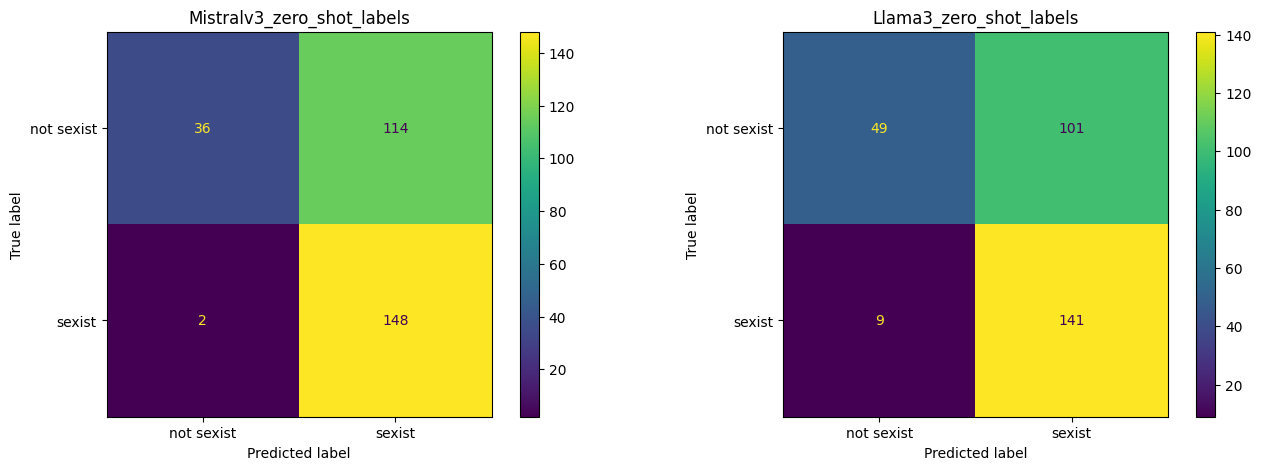

,model,accuracy,fail_ratio
7,Llama3_0_shot,0.633333,0.366667
0,Mistralv3_0_shot,0.613333,0.386667


In [27]:
print_models_confusion_matrix(['Mistralv3_zero_shot_labels', 'Llama3_zero_shot_labels'], models_predictions)

zero_shot_df = model_metrics[model_metrics['model'].str.contains('_0_shot', case=False)]
zero_shot_df.sort_values('accuracy', ascending=False)

LLaMA 3 outperforms Mistral v3 in zero-shot inference.
The confusion matrix reveals that most errors made by both models involve misclassifying non-sexist tweets as sexist.

Notably, Mistral v3 misclassifies over 75% of non-sexist tweets as sexist, whereas LLaMA 3 misclassifies only 64% of non-sexist tweets as sexist.
Additionally, only a very small portion of comments classified as sexist are misclassified as non-sexist: 1.3% for Mistral v3 and 4.7% for LLaMA 3.

This discrepancy may be due to several factors. The training data might be imbalanced, with more examples of sexist comments, leading to better recognition of sexist patterns. Sexist comments could also have more distinctive linguistic features, making them easier to identify. Additionally, biases in annotation and the need for nuanced understanding of non-sexist comments might contribute to the models' difficulties.

One possible reason for the models being trained on unbalanced data is that the developers aimed to address the generation of unsuitable content. The techniques employed to prevent the generation of such content might have inadvertently led to a significant imbalance between the recognition of the two classes. This imbalance could result in the models being more adept at identifying one class over the other, thus affecting their overall performance.

In [22]:
print_misslabeled_tweets('Mistralv3', ['Mistralv3_zero_shot_labels'], misslabel_type="fn", text_limit=10)

Sexist labeled tweet classified as not sexist by Mistralv3

Analyzing Mistralv3_zero_shot_labels:
row 8) That's female fantasy. I have a lot of experience in that field and nurses marry doctors all the time. Something statistics also support. 
row 140) Karma's a bitch! 


In [23]:
print_misslabeled_tweets('Llama3', ['Llama3_zero_shot_labels'], misslabel_type="fn", text_limit=10)

Sexist labeled tweet classified as not sexist by Llama3

Analyzing Llama3_zero_shot_labels:
row 8) That's female fantasy. I have a lot of experience in that field and nurses marry doctors all the time. Something statistics also support. 
row 59) Greens, eh? The fateful question of the Occident is thus now whether young female university graduates can be continually served with yoga and Pilates courses even amidst the ruins looming on the horizon. 
row 142) What's the going timeframe onto getting on GAB nowadays??? I'm trying to recruit hardcore since twat is going crazy with censorship. 
row 180) Looks like a tranny witch 
row 220) what have you tried already? I like to point out that nobody blinks when a smaller man starts shit with a larger man and gets his ass beat, men and women are equal right? 
row 238) Not all Blacks are complete NIGGERS like this whore The Pure POS Nigger bitch gives others a bad name fucking cunt Should investigate where she worked and deaths 
row 245) To fema

The comments misclassified by Mistral v3 are clearly mislabeled, whereas those misclassified by LLaMA 3 are clearly false negatives. This suggests that Mistral v3 received training that better enables it to identify sexist comments compared to LLaMA 3. This difference in performance may be attributed to the specific techniques used during training, which might have focused more on recognizing and preventing the generation of unsuitable content. Consequently, this focus could have led to an imbalance in the training data, enhancing Mistral v3's ability to detect sexist comments but also increasing the likelihood of misclassifying non-sexist comments.

### Task 6.3 - Model performance evaluation with few shot inference


In the next session, we will compare the performance of the base models with various few-shot techniques. The base model will serve as a baseline to evaluate the extent of improvements achieved through few-shot prompting. We aim to determine whether a model that performs poorly with zero-shot inference can improve when provided with a few examples in the prompt. Additionally, we will identify the most effective few-shot technique for the task of labeling comments as sexist or non-sexist. This analysis will help us understand the potential of few-shot learning in enhancing model accuracy for this specific classification task.

#### Few shot with ramdomly sampled examplse from the dataset



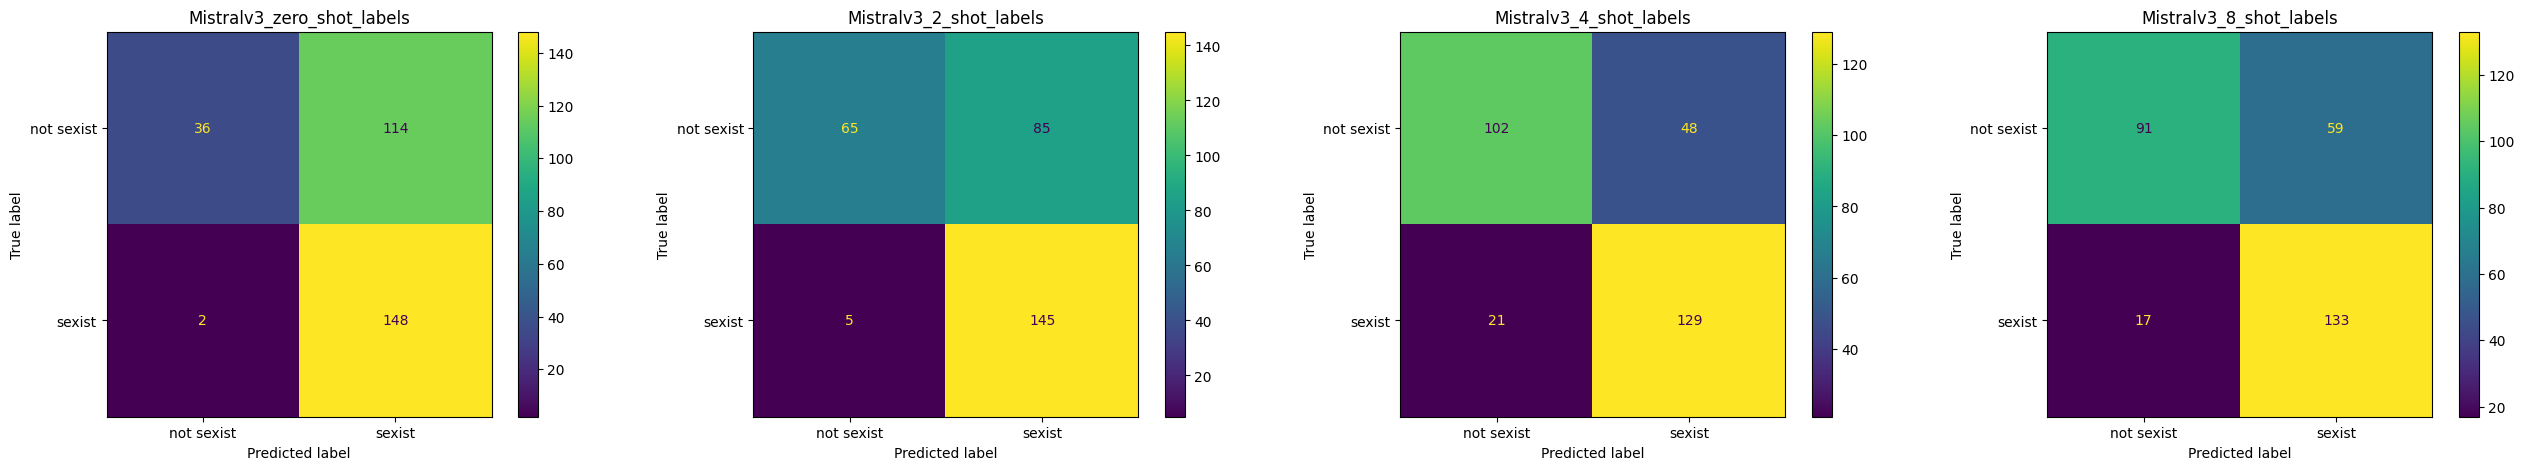

,model,accuracy,fail_ratio
2,Mistralv3_4_shot,0.770000,0.230000
3,Mistralv3_8_shot,0.746667,0.253333
1,Mistralv3_2_shot,0.700000,0.300000
0,Mistralv3_0_shot,0.613333,0.386667


In [24]:
mistral_models_labels = ['Mistralv3_zero_shot_labels', 'Mistralv3_2_shot_labels', 'Mistralv3_4_shot_labels', 'Mistralv3_8_shot_labels']
print_models_confusion_matrix(mistral_models_labels, models_predictions)
mistral_base_prompting =  model_metrics[model_metrics['model'].str.contains('Mistral', case=False) & ~model_metrics['model'].str.endswith('custom')]
mistral_base_prompting.sort_values('accuracy', ascending=False)

The results indicate that Mistral v3's performance improves with two-shot examples, achieving an accuracy of 0.700000 compared to the zero-shot baseline of 0.613333. However, increasing the number of examples to four or eight yields further improvements, with the four-shot model achieving an accuracy of 0.770000 and the eight-shot model achieving an accuracy of 0.746667. This demonstrates that while additional examples generally enhance performance, the most significant improvement is observed with the four-shot model.

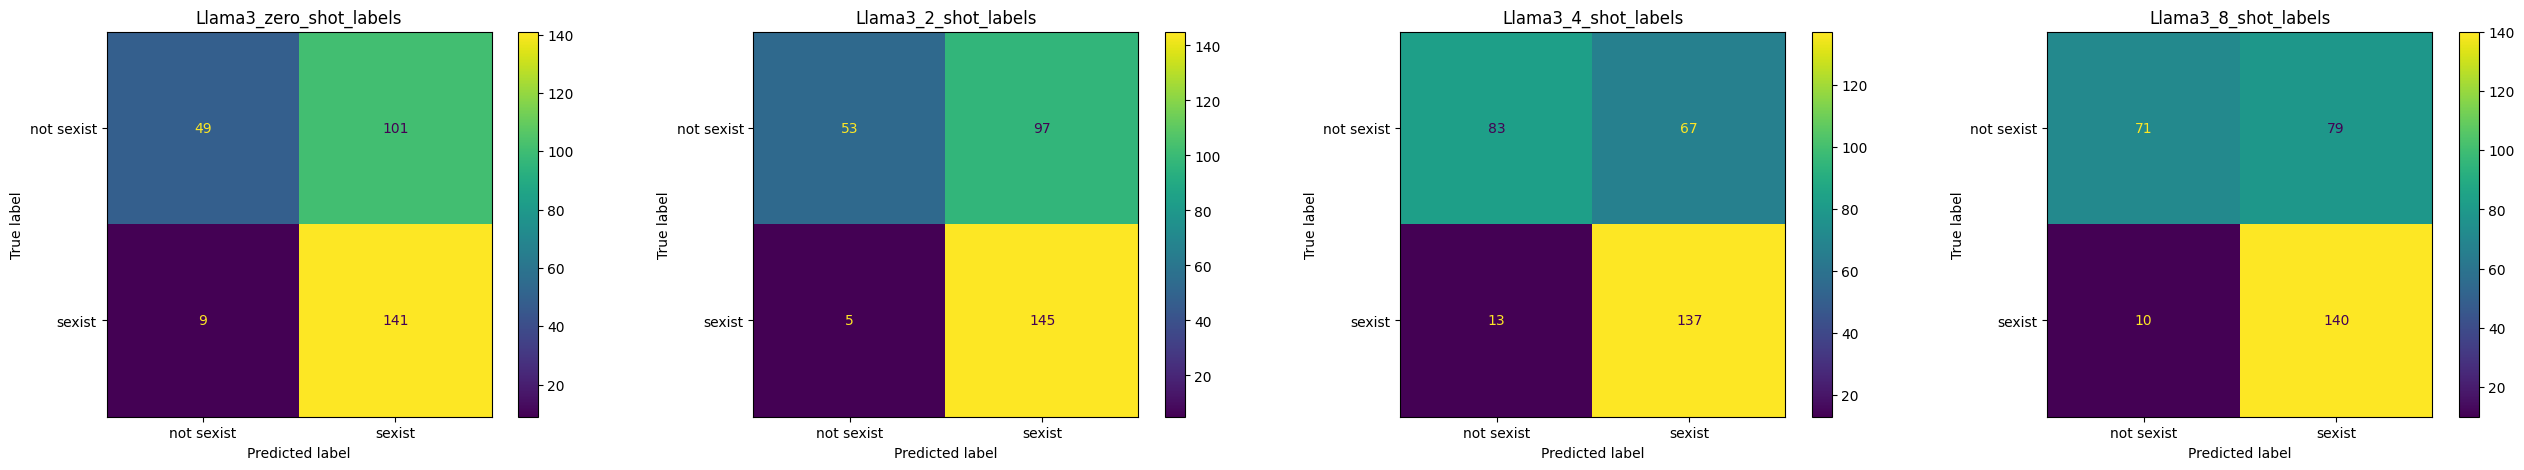

,model,accuracy,fail_ratio
10,Llama3_4_shot,0.733333,0.266667
11,Llama3_8_shot,0.703333,0.296667
9,Llama3_2_shot,0.660000,0.340000
7,Llama3_0_shot,0.633333,0.366667
8,Llama3_0_shot,0.633333,0.366667


In [25]:
llama_models_labels = ['Llama3_zero_shot_labels', 'Llama3_2_shot_labels', 'Llama3_4_shot_labels', 'Llama3_8_shot_labels']
print_models_confusion_matrix(llama_models_labels, models_predictions)
llama3_base_prompting =  model_metrics[model_metrics['model'].str.contains('Llama3', case=False) & ~model_metrics['model'].str.endswith('custom')]
llama3_base_prompting.sort_values('accuracy', ascending=False)

The table shows that LLaMA 3's performance improves with two-shot and four-shot examples, achieving the highest accuracy of 0.690000 with four-shot examples. However, the eight-shot model performs worse than the zero-shot model, with a decline in accuracy to 0.623333. This suggests that while a few examples can enhance performance, too many examples can degrade it.


We suspect that the inconsistent performance in both models is due to the poor quality of the examples used in multiple-shot learning. These examples were randomly extracted from the dataset, which may have led to suboptimal training and the observed lack of improvement. It is important to note that, despite being random, the models were prompted with the same textual prompt for each respective prompting technique.

To eliminate the potential problems associated with random selection and better assess the models' performance and to verify the previus claims, we conducted another evaluation of the prompt. This time, the examples injected into the prompt were manually checked by us in order to avoid issues arising from mislabeled or non-meaningful examples.

#### Few shot with topK demonstration examples from the dataset

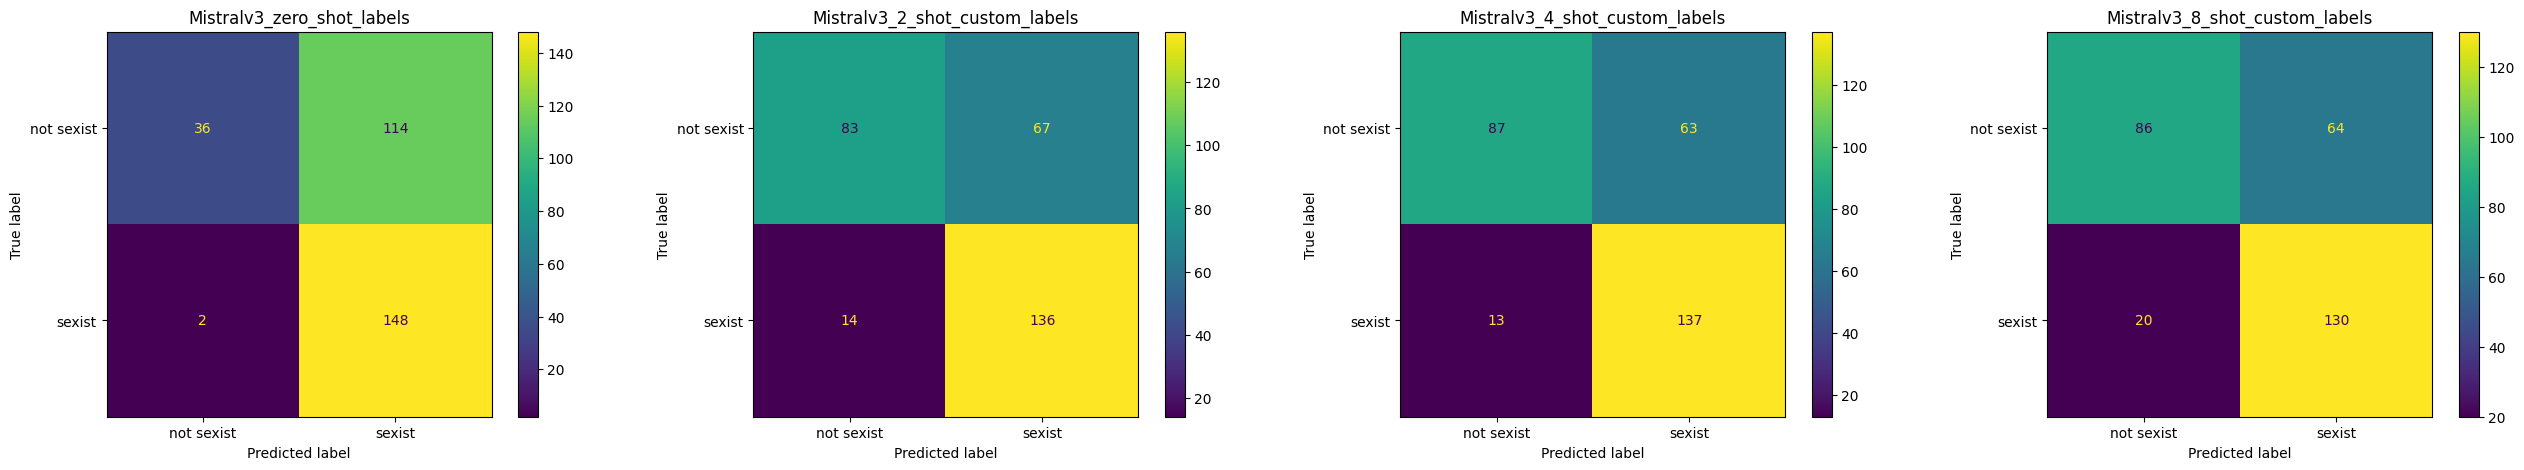

,model,accuracy,fail_ratio
5,Mistralv3_4_shot_custom,0.746667,0.253333
4,Mistralv3_2_shot_custom,0.730000,0.270000
6,Mistralv3_8_shot_custom,0.720000,0.280000


In [28]:
mistral_models_labels = ['Mistralv3_zero_shot_labels', 'Mistralv3_2_shot_custom_labels', 'Mistralv3_4_shot_custom_labels', 'Mistralv3_8_shot_custom_labels']
print_models_confusion_matrix(mistral_models_labels, models_predictions)
mistral_base_prompting = model_metrics[model_metrics['model'].str.contains('Mistral', case=False) &
                                                    (model_metrics['model'].str.endswith('custom') | model_metrics['model'].str.endswith('zero shot'))]
mistral_base_prompting.sort_values('accuracy', ascending=False)

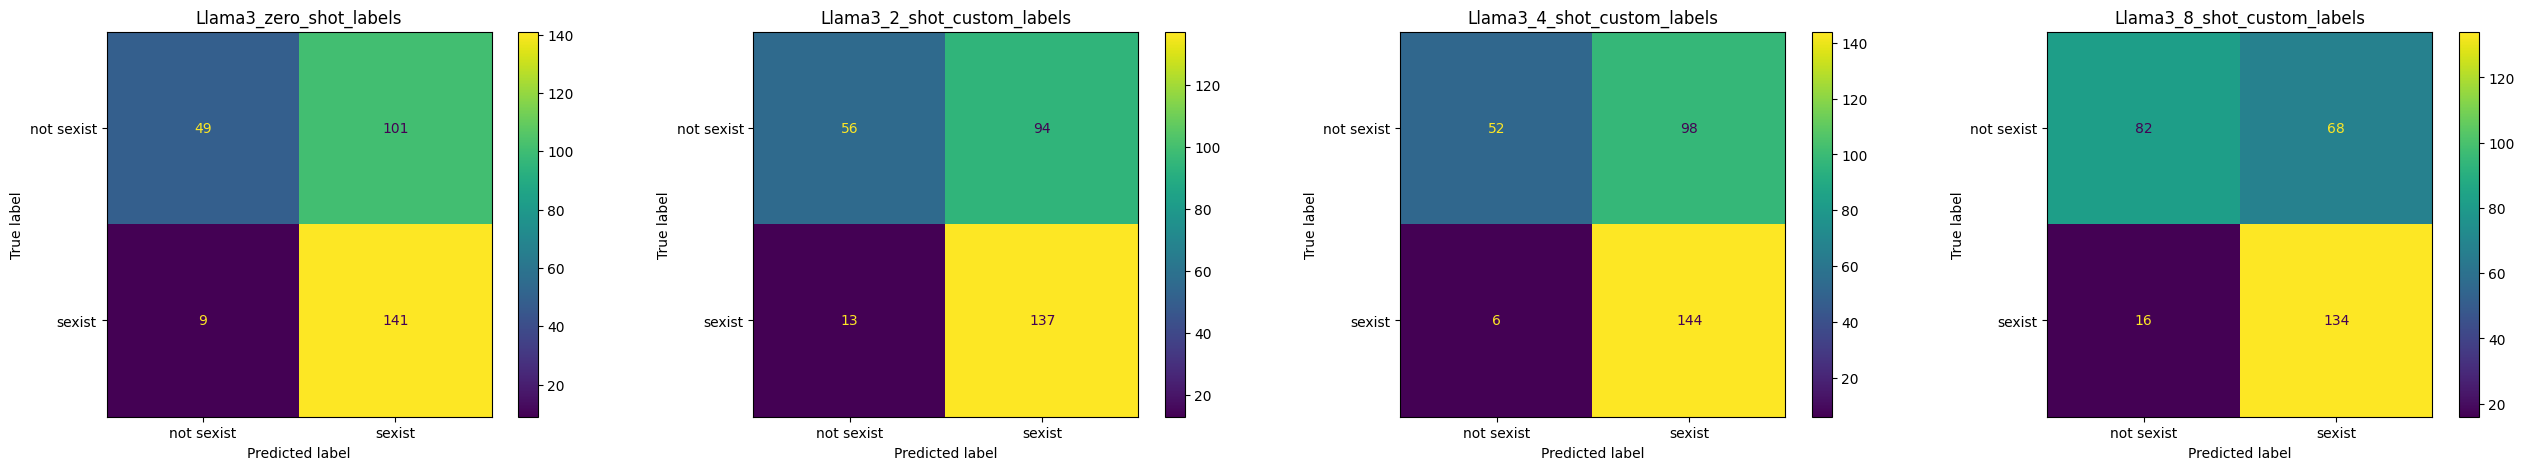

,model,accuracy,fail_ratio
14,Llama3_8_shot_custom,0.720000,0.280000
13,Llama3_4_shot_custom,0.653333,0.346667
12,Llama3_2_shot_custom,0.643333,0.356667


In [29]:
llama_models_labels = ['Llama3_zero_shot_labels', 'Llama3_2_shot_custom_labels', 'Llama3_4_shot_custom_labels', 'Llama3_8_shot_custom_labels']
print_models_confusion_matrix(llama_models_labels, models_predictions)
mistral_base_prompting = model_metrics[model_metrics['model'].str.contains('Llama3', case=False) &
                                                    (model_metrics['model'].str.endswith('custom') | model_metrics['model'].str.endswith('zero shot'))]
mistral_base_prompting.sort_values('accuracy', ascending=False)

The performance of Mistral v3 and LLaMA 3 with manually labeled examples in the prompt shows significant improvements over their zero-shot baselines. For Mistral v3, the zero-shot model has an accuracy of 0.61 and a fail ratio of 0.38. With two-shot manually labeled examples, the accuracy improves to 0.64, and further increases to 0.67 with four-shot examples. The eight-shot model achieves the highest accuracy of 0.72 and the lowest fail ratio of 0.28.

Similarly, LLaMA 3's zero-shot model has an accuracy of 0.65 and a fail ratio of 0.34. The accuracy slightly improves to 0.65 with two-shot examples and further to 0.66 with four-shot examples. The eight-shot model achieves an accuracy of 0.66, which is slightly lower than the four-shot model but still better than the zero-shot baseline.

These results confirm that manually labeled examples significantly enhance the performance of both models compared to randomly selected examples, highlighting the importance of carefully choosing the examples to be injected into the prompt.

### Task 6.4 Best prompting technique error analisys  

The objective of this section is to visualize the errors made by the two models using their best prompting techniques identified in the previous section. This analysis will help us identify the types of errors most commonly committed by the models, providing insights into areas where further improvements are needed.

We start analysing the comment misslcassified as non sexist (false negative)  

In [ ]:
print_misslabeled_tweets('Mistralv3', ["Mistralv3_8_shot_custom_labels"], misslabel_type="fn", text_limit=10)

Sexist labeled tweet classified as not sexist by Mistralv3

Analyzing Mistralv3_8_shot_custom_labels:
row 5) Don't think that using the word "feminine" wasn't strategic, Mo. It was. And I couldn't agree more with everything else you wrote. They attempt to bring the rest of us down to their level. Not gonna happen ... Lol, men are a gift from God. 
row 8) That's female fantasy. I have a lot of experience in that field and nurses marry doctors all the time. Something statistics also support. 
row 12) Thanks for the response brotha, I'll work towards it. It's just another nasty remnant of my beta days. But like you said, I'm a man. Men conquer. 
row 18) How long will it take a woman to mentally move on from the situation? Cause they're fond of bringing up shit from before my ancestors 
row 37) Why do women settle down with you after you spent your youth getting your dick wet with as many different pussies as you can? Because people change over time, they mature, they become different than

In [30]:
print_misslabeled_tweets('Llama3', ["Llama3_4_shot_custom_labels"], misslabel_type="fn", text_limit=10)

Sexist labeled tweet classified as not sexist by Llama3

Analyzing Llama3_4_shot_custom_labels:
row 8) That's female fantasy. I have a lot of experience in that field and nurses marry doctors all the time. Something statistics also support. 
row 59) Greens, eh? The fateful question of the Occident is thus now whether young female university graduates can be continually served with yoga and Pilates courses even amidst the ruins looming on the horizon. 
row 140) Karma's a bitch! 
row 142) What's the going timeframe onto getting on GAB nowadays??? I'm trying to recruit hardcore since twat is going crazy with censorship. 
row 220) what have you tried already? I like to point out that nobody blinks when a smaller man starts shit with a larger man and gets his ass beat, men and women are equal right? 
row 249) I know mine is higher with smart women than dumb women. Or rather, it's lower with dumb women because my lack of knowledge or interest in what (Insert celebrity) did comes across as pa

Add comment here of the false negative

In [ ]:
print_misslabeled_tweets('Mistralv3', ["Mistralv3_8_shot_custom_labels"], misslabel_type="fp", text_limit=10)

Not sexist labeled tweet classified as sexist by Mistralv3

Analyzing Mistralv3_8_shot_custom_labels:
row 3) Excellent, I was just looking at another post where the female fvcked men to get grades, why support that, or even risk exposing ourselves to that type of fraudulent behavior. 
row 6) ‪Import the third world and become the third world. You won’t see feminists protesting about this. ‬ ‪[URL] 
row 10) The black African will soon be labeling her a racist. Race card coming soon 
row 26) Good - the grid girls can finally get back into F1 
row 27) #Italy: #Muslim #migrant gropes American student’s girlfriend, then #stabs the student twice: [URL] 
row 34) I'm his first ever girlfriend Incels do not get girlfriends ever 
row 44) They are just so pissed off cuz no woman wants neither one of them and they know it. Both little fat round pigs who probably play tiddlywinks together! 
row 48) First. Black Democrats upset that Black unemployment is down. Now. Feminists upset with good looking 

In [31]:
print_misslabeled_tweets('Llama3', ["Llama3_4_shot_custom_labels"], misslabel_type="fp", text_limit=10)

Not sexist labeled tweet classified as sexist by Llama3

Analyzing Llama3_4_shot_custom_labels:
row 3) Excellent, I was just looking at another post where the female fvcked men to get grades, why support that, or even risk exposing ourselves to that type of fraudulent behavior. 
row 6) ‪Import the third world and become the third world. You won’t see feminists protesting about this. ‬ ‪[URL] 
row 7) Most women find a highly educated and well traveled man sexy. 
row 10) The black African will soon be labeling her a racist. Race card coming soon 
row 14) The queen is not representing herself and a direct descendant of Muhammad & high up in the Catholic church of the illuminati ... so are you surprised about this abuse of children? 
row 23) I get the impression that incel never skipped a meal in his life. 
row 26) Good - the grid girls can finally get back into F1 
row 32) Before I decided to sack Twitter off entirely, I muted about 100 terms, things like Feminism, sexism, racism, Trump, 

# Task 7 - Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...

# FAQ

Please check this frequently asked questions before contacting us.

### Model cards

You can pick any open-source model card you like.

We recommend starting from those reported in this assignment.

### Implementation

Everything can be done via ``transformers`` APIs.

However, you are free to test frameworks, such as [LangChain](https://www.langchain.com/), [LlamaIndex](https://www.llamaindex.ai/) [LitParrot](https://github.com/awesome-software/lit-parrot), provided that you correctly address task instructions.

### Bonus Points

0.5 bonus points are arbitrarily assigned based on significant contributions such as:

- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
- Evaluate A1 dataset and perform comparison

Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

### Prompt Template

Do not change the provided prompt template.

You are only allowed to change it in case of a possible extension.

### Optimizations

Any kind of code optimization (e.g., speedup model inference or reduce computational cost) is more than welcome!

# The End